<a href="https://colab.research.google.com/github/Rephonic/STDM_coursework/blob/main/STDMR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data prepare

In [ ]:
library(sf)
library(forecast)
library(dplyr)
library(sp)
library(spacetime)
library(scales)
library(spatstat)
library(spdep)
library(readr)
library(ggplot2)
library(patchwork)


In [1]:
source("starima_package.R")

In [ ]:
install.packages('forecast')
install.packages('sf')
install.packages('ggplot2')
install.packages('dplyr')
install.packages('sp')
install.packages('spacetime')
install.packages('scales')
install.packages('spatstat')
install.packages('spdep')
install.packages('readr')
install.packages('patchwork')

Import Data

In [4]:
crime_data <- read.csv("sorted_pivoted_monthly_district_cases_df.csv")
crime_matrix <- data.matrix(crime_data)
crime_matrix <- crime_matrix[-121, -1 ]
transposed_crime_matrix <- t(crime_matrix)

theft_data <- read.csv("THEFT_wide_format.csv")
theft_matrix <- data.matrix(theft_data)
theft_matrix <- theft_matrix[-121, -1 ]
transposed_theft_matrix <- t(theft_matrix)

battery_data <- read.csv("BATTERY_wide_format.csv")
battery_matrix <- data.matrix(battery_data)
battery_matrix <- battery_matrix[-121, -1 ]
transposed_battery_matrix <- t(battery_matrix)

criminal_data <- read.csv("CRIMINAL DAMAGE_wide_format.csv")
criminal_matrix <- data.matrix(criminal_data)
criminal_matrix <- criminal_matrix[-121, -1 ]
transposed_criminal_matrix <- t(criminal_matrix)

Reading layer `poldist' from data source `/content/poldist.shp' using driver `ESRI Shapefile'
Simple feature collection with 26 features and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -87.9402 ymin: 41.64431 xmax: -87.524 ymax: 42.02313
Geodetic CRS:  NAD83


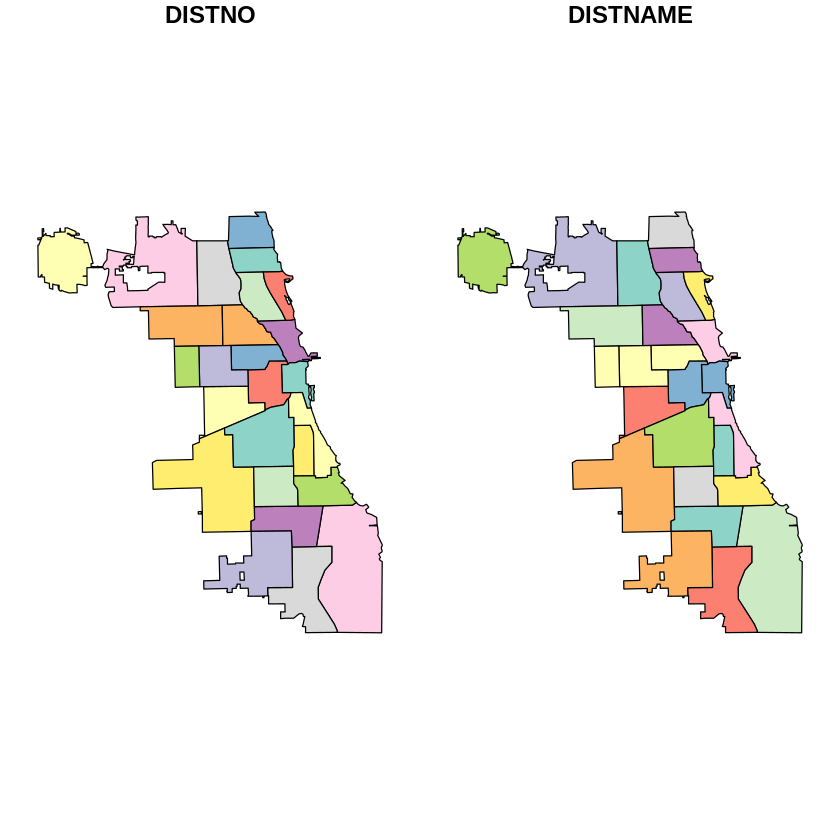

In [8]:
chicago_district <- st_read("poldist.shp")

crs <- st_crs("+proj=longlat +datum=WGS84 +no_defs")

chicago_district84 <- st_transform(chicago_district, crs = crs)
plot(chicago_district84)

# EDA - Non spatial temporal

In [ ]:
crime_mean = mean(crime_matrix)
theft_mean = mean(theft_matrix)
battery_mean = mean(battery_matrix)
criminal_mean = mean(criminal_matrix)

crime_mean
theft_mean
battery_mean
criminal_mean

[1] 794.9939

[1] 177.4734

[1] 147.8837

[1] 88.47788

In [ ]:
crime_sdev = sd(crime_matrix)
theft_sdev = sd(theft_matrix)
battery_sdev = sd(battery_matrix)
criminal_sdev = sd(criminal_matrix)

crime_sdev
theft_sdev
battery_sdev
criminal_sdev

[1] 345.83

[1] 103.0405

[1] 82.24622

[1] 44.6803

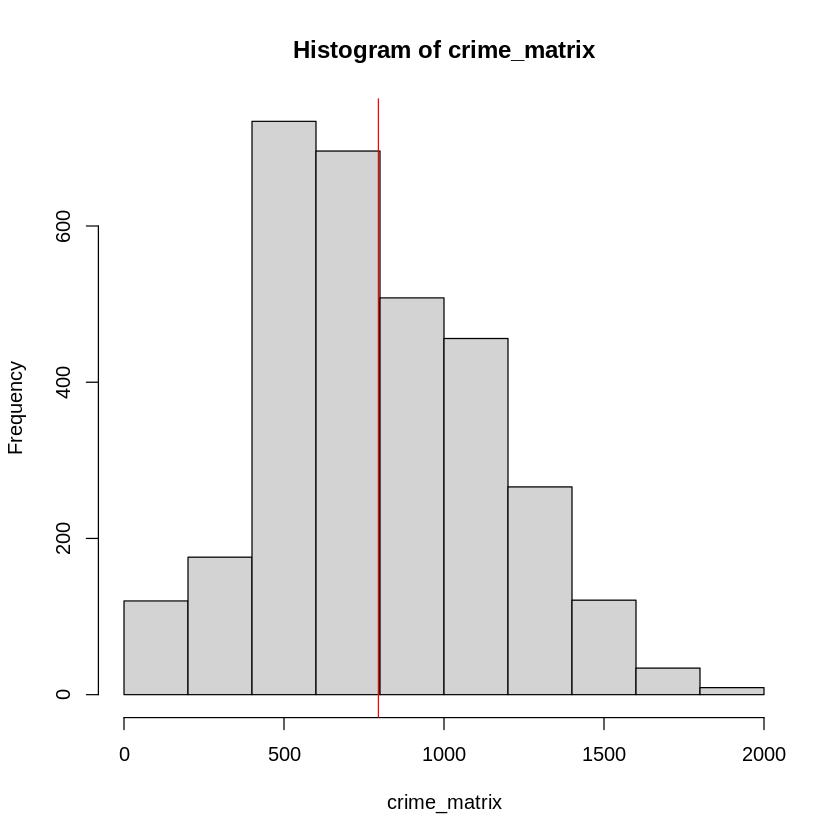

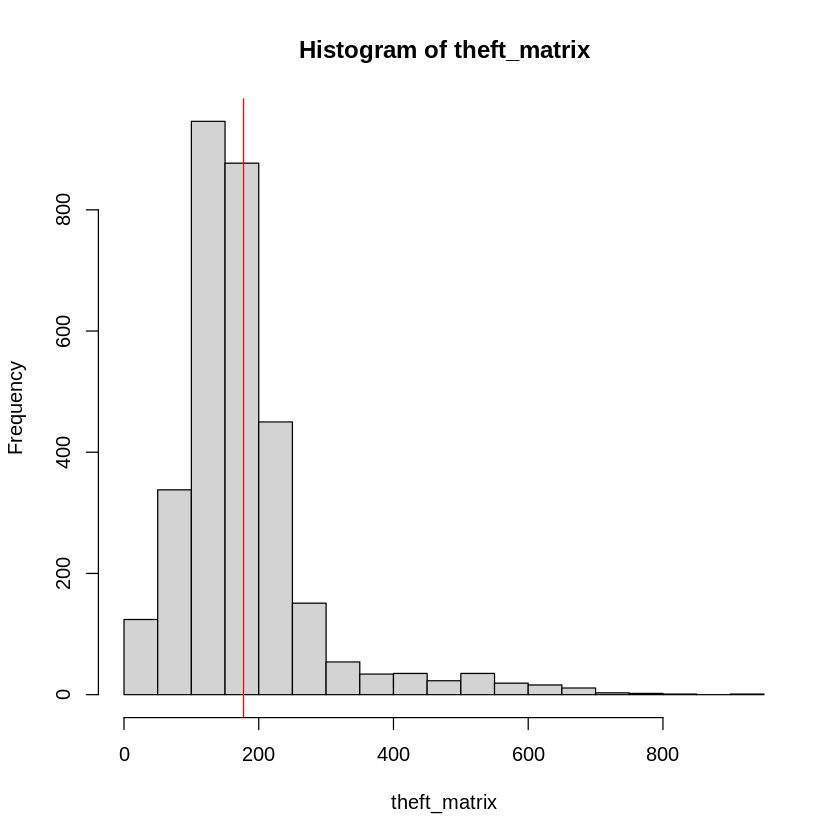

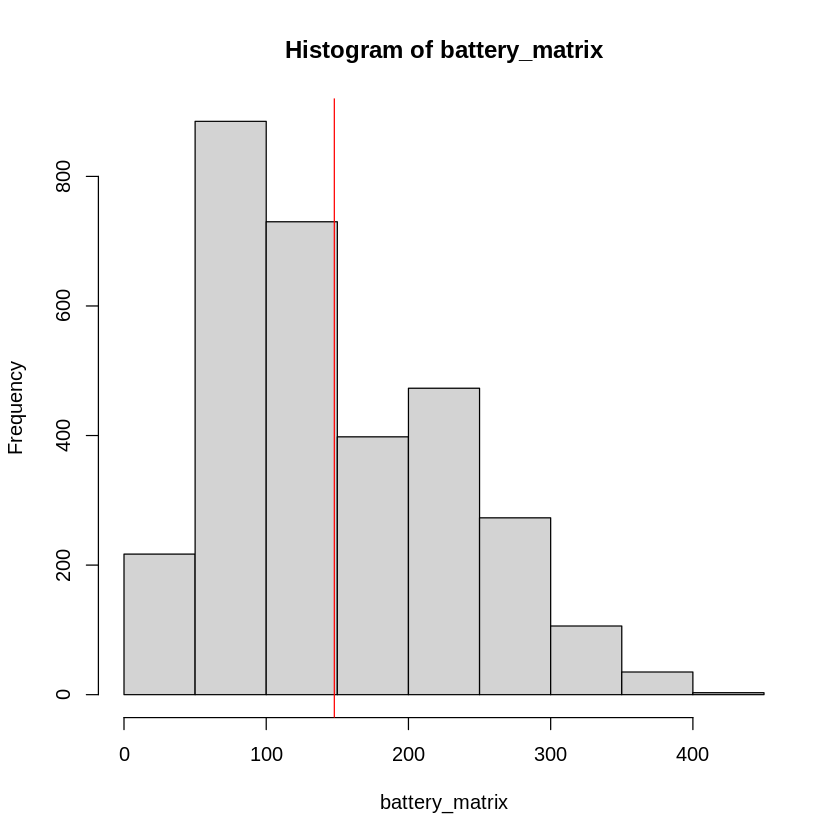

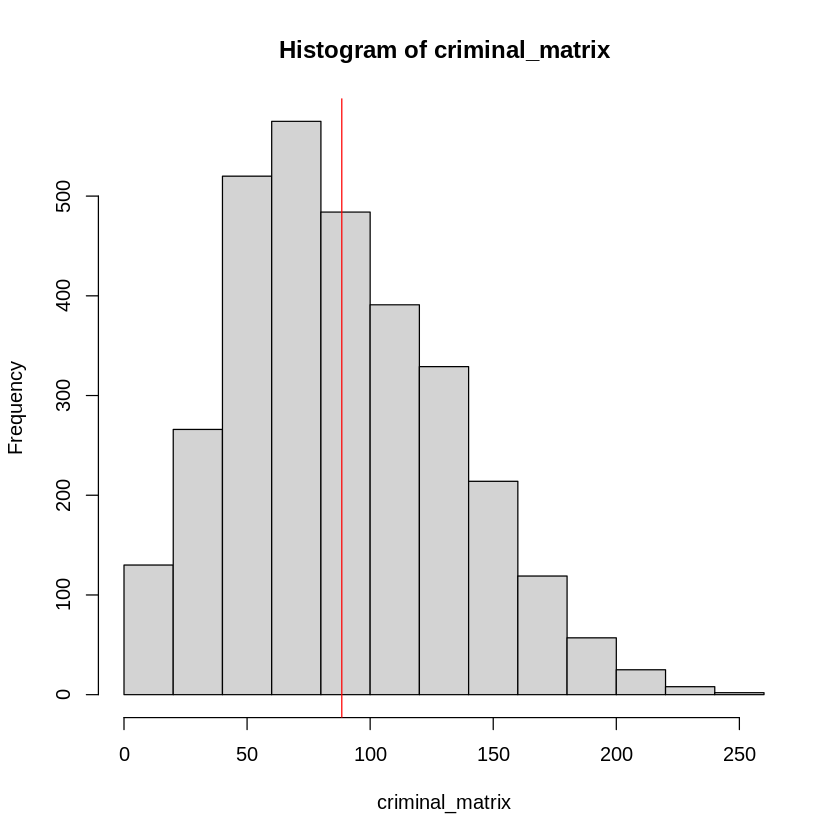

In [ ]:
hist(crime_matrix)
abline(v=crime_mean, col="red")

hist(theft_matrix)
abline(v=theft_mean, col="red")

hist(battery_matrix)
abline(v=battery_mean, col="red")

hist(criminal_matrix)
abline(v=criminal_mean, col="red")

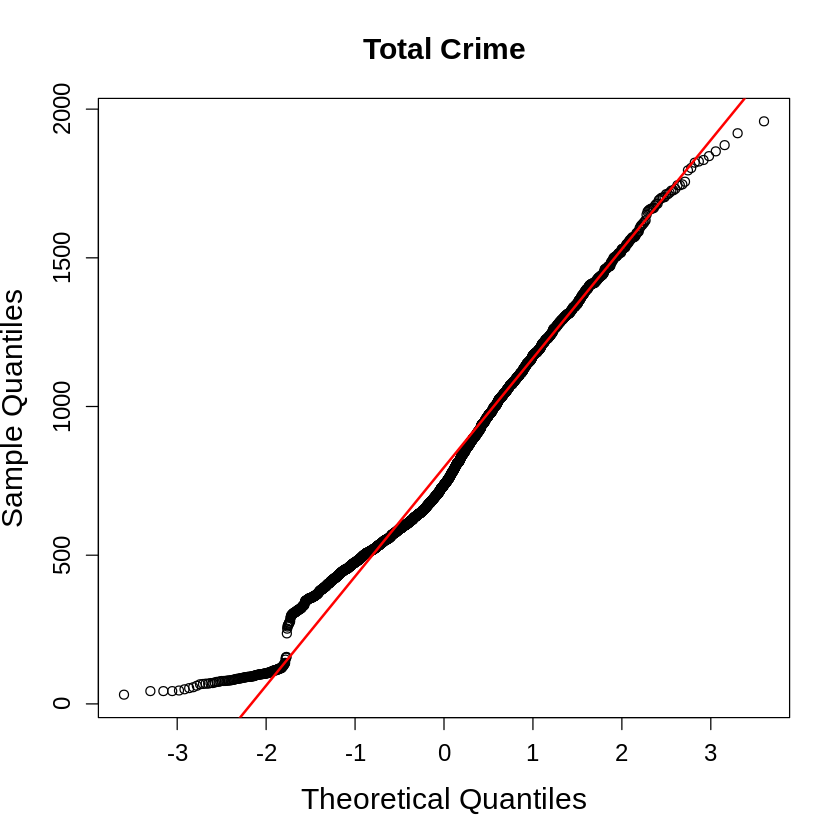

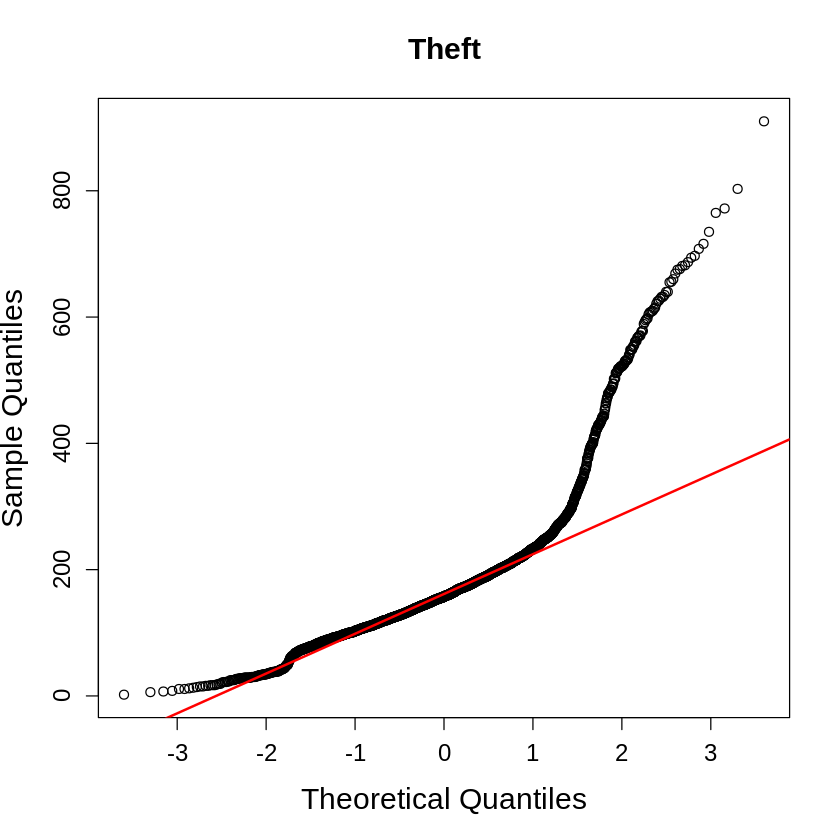

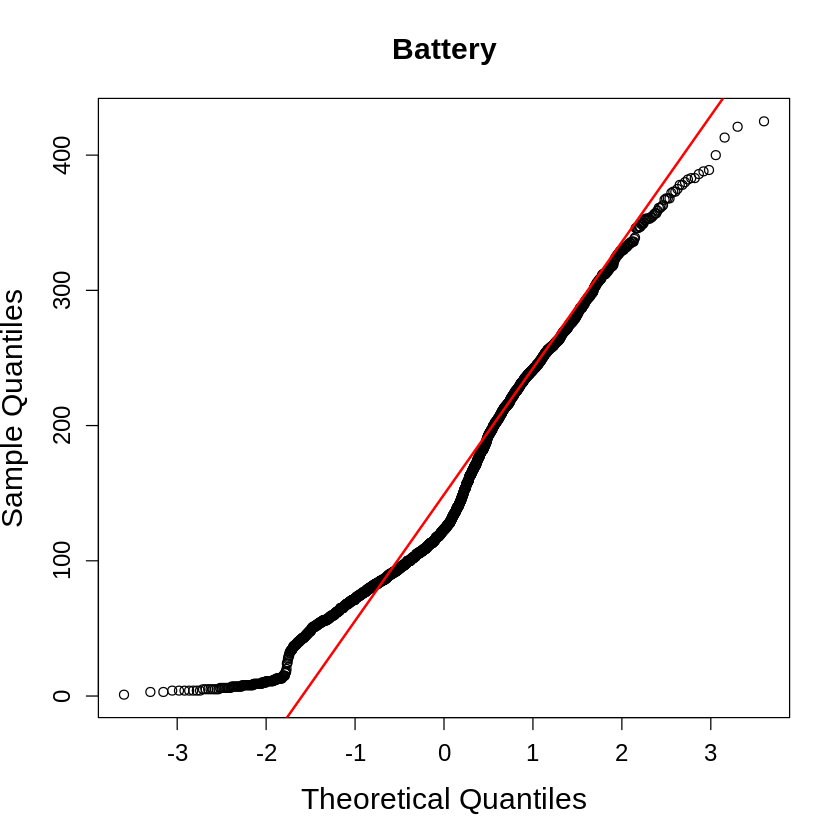

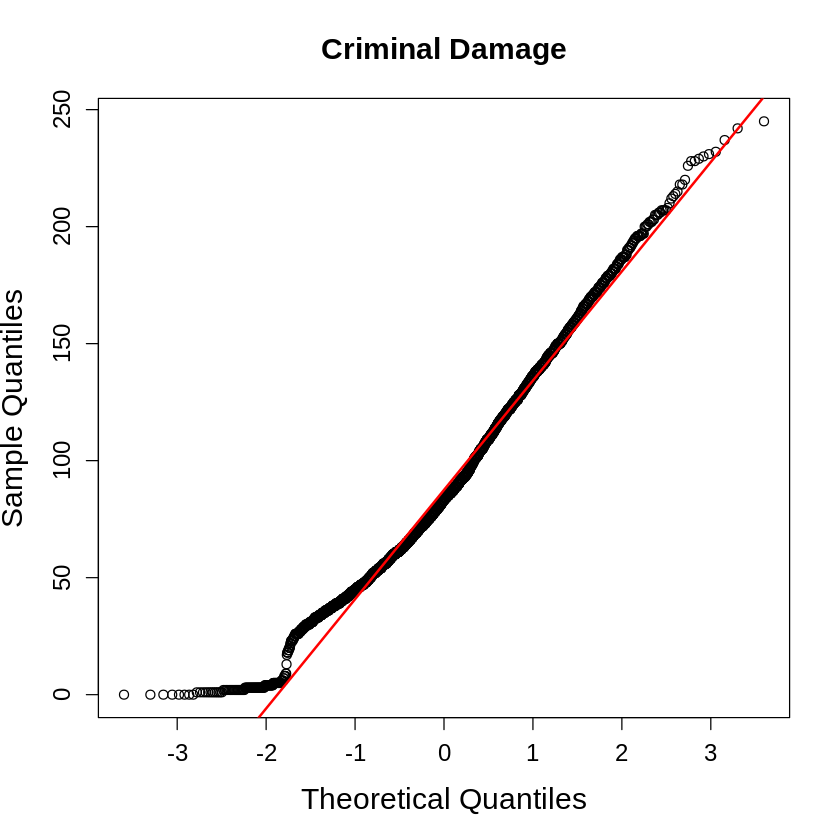

In [ ]:
qqnorm(crime_matrix, main="Total Crime", cex.lab=1.5, cex.axis=1.2, cex.main=1.5)
qqline(crime_matrix, col="red", lwd=2)

qqnorm(theft_matrix, main="Theft", cex.lab=1.5, cex.axis=1.2, cex.main=1.5)
qqline(theft_matrix, col="red", lwd=2)

qqnorm(battery_matrix, main="Battery", cex.lab=1.5, cex.axis=1.2, cex.main=1.5)
qqline(battery_matrix, col="red", lwd=2)

qqnorm(criminal_matrix, main="Criminal Damage", cex.lab=1.5, cex.axis=1.2, cex.main=1.5)
qqline(criminal_matrix, col="red", lwd=2)



# EDA-Spatial

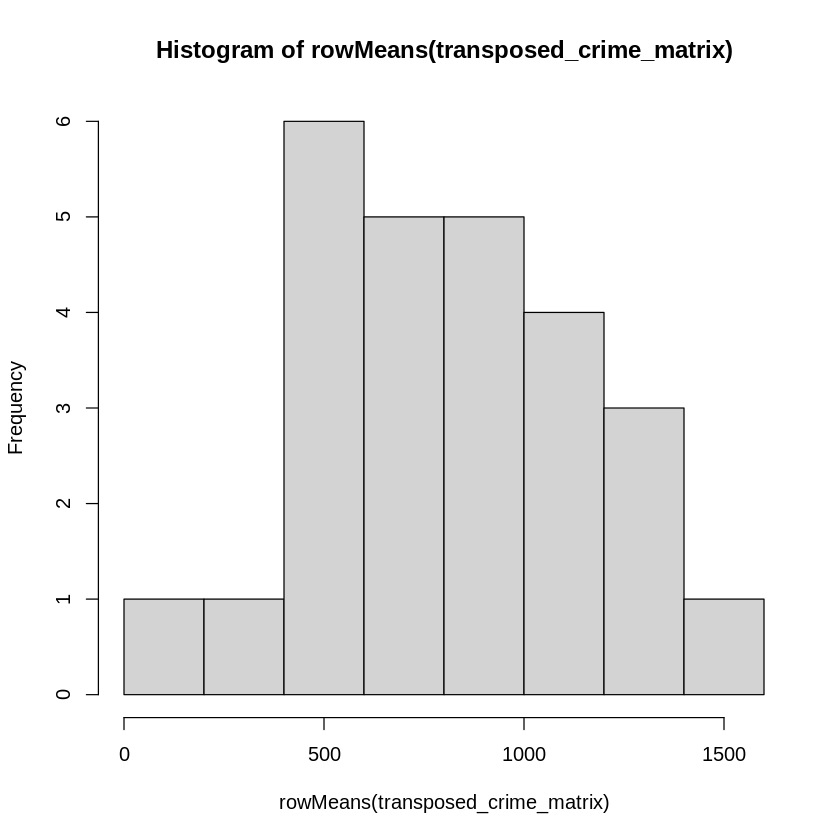

In [ ]:
hist(rowMeans(transposed_crime_matrix))

Spatial autocorrelation - county

In [ ]:
crime_data_long <- read.csv("monthly_3type_long.csv")
summary(crime_data_long)

In [ ]:
#aggregat by county and type
aggregated_crime_data <- aggregate(CaseCount ~ DISTNO + PrimaryType, data=crime_data_long, sum)

In [ ]:
theft_agg_data <- subset(aggregated_crime_data, PrimaryType == 'THEFT')
battery_agg_data <- subset(aggregated_crime_data, PrimaryType == 'BATTERY')
criminal_agg_data <- subset(aggregated_crime_data, PrimaryType == 'CRIMINAL DAMAGE')

In [ ]:
#Join the data to the spatial units
theft_merged_data <- merge(chicago_district84, theft_agg_data, by="DISTNO")
battery_merged_data <- merge(chicago_district84, battery_agg_data, by="DISTNO")
criminal_merged_data <- merge(chicago_district84, criminal_agg_data, by="DISTNO")
merged_data <- merge(chicago_district84, aggregated_crime_data, by="DISTNO")

In [ ]:
# There's no neibour in OH district - calculate theft_moran_result
filtered_data <- theft_merged_data[theft_merged_data$DISTNO != 'OH', ]
neighbors <- poly2nb(filtered_data)
W <- nb2listw(neighbors, style="W")
theft_moran_result <- moran.test(filtered_data$CaseCount, W)
theft_moran_result


	Moran I test under randomisation

data:  filtered_data$CaseCount  
weights: W    

Moran I statistic standard deviate = 2.1768, p-value = 0.01475
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       0.21004320       -0.04166667        0.01337038 


In [ ]:
filtered_data <- battery_merged_data[battery_merged_data$DISTNO != 'OH', ]
neighbors <- poly2nb(filtered_data)
W <- nb2listw(neighbors, style="W")
battery_moran_result <- moran.test(filtered_data$CaseCount, W)
battery_moran_result


	Moran I test under randomisation

data:  filtered_data$CaseCount  
weights: W    

Moran I statistic standard deviate = 3.9763, p-value = 3.499e-05
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       0.48797322       -0.04166667        0.01774159 


In [ ]:
filtered_data <- criminal_merged_data[criminal_merged_data$DISTNO != 'OH', ]
neighbors <- poly2nb(filtered_data)
W <- nb2listw(neighbors, style="W")
criminal_moran_result <- moran.test(filtered_data$CaseCount, W)
criminal_moran_result


	Moran I test under randomisation

data:  filtered_data$CaseCount  
weights: W    

Moran I statistic standard deviate = 4.3577, p-value = 6.573e-06
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       0.53325585       -0.04166667        0.01740654 


In [ ]:
filtered_data <- merged_data[merged_data$DISTNO != 'OH', ]
neighbors <- poly2nb(filtered_data)
W <- nb2listw(neighbors, style="W")
moran_result <- moran.test(filtered_data$CaseCount, W)
moran_result


	Moran I test under randomisation

data:  filtered_data$CaseCount  
weights: W    

Moran I statistic standard deviate = 1.4621, p-value = 0.07186
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.042934828      -0.013513514       0.001490646 


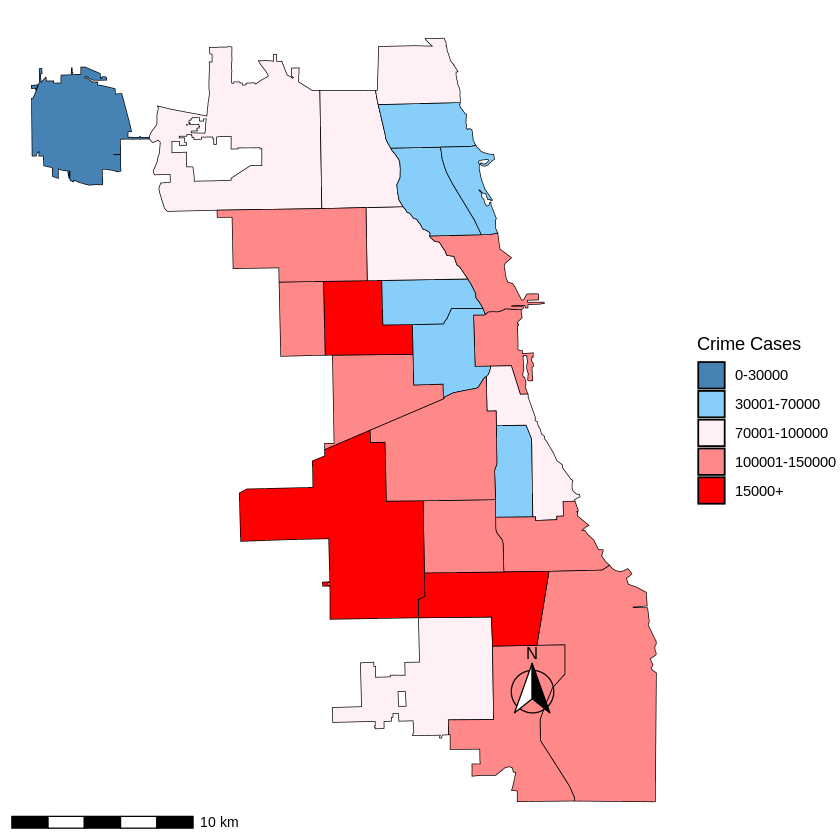

In [ ]:
#plot the total number of crime cases in district
breaks <- c(0, 30000, 70000, 100000, 150000, Inf)
labels <- c("0-30000", "30001-70000", "70001-100000", "100001-150000","15000+")
colors <- c("#4682B4", "#87CEFA", "#FFF0F5", "#ff8888", "#ff0000")
merged_data$CrimeClass <- cut(merged_data$CaseCount, breaks = breaks, labels = labels, include.lowest = TRUE)


ggplot(data = merged_data) +
  geom_sf(aes(fill = CrimeClass), color = 'black') +
  scale_fill_manual(values = colors, name = "Crime Cases") +
  theme_void() +
  theme(legend.position = "right") +
  annotation_north_arrow(location = "br",
                         which_north = "true",
                         pad_x = unit(1, "in"), pad_y = unit(1, "in"),
                         style = north_arrow_fancy_orienteering()) +
  annotation_scale(location = "bl", width_hint = 0.5)

# EDA-Temporal

In [ ]:
#Set year Label and District Label
start_year <- 2014
start_month <- 1
total_months <- ncol(transposed_crime_matrix)

year_month_labels <- sapply(0:(total_months - 1), function(i) {
  year = start_year + (start_month + i - 1) %/% 12
  month = (start_month + i - 1) %% 12 + 1
  date_str = sprintf("%04d-%02d-01", year, month)

  date = as.Date(date_str)
  format(date, "%Y%m")
})


district_labels <- as.character(1:nrow(transposed_crime_matrix))

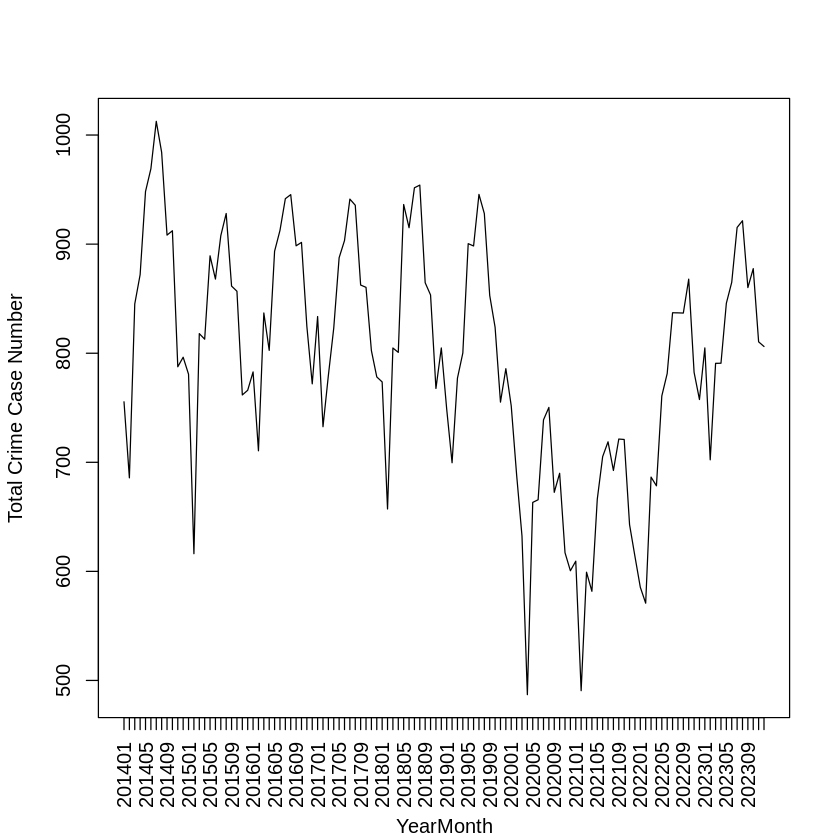

In [ ]:
plot(rowMeans(crime_matrix), xlab = "", ylab = "Total Crime Case Number", type="l", xaxt="n")
at_positions <- seq_along(rowMeans(crime_matrix))
axis(1, at=at_positions, labels=year_month_labels, las=2)
mtext("YearMonth", side=1, line=4)

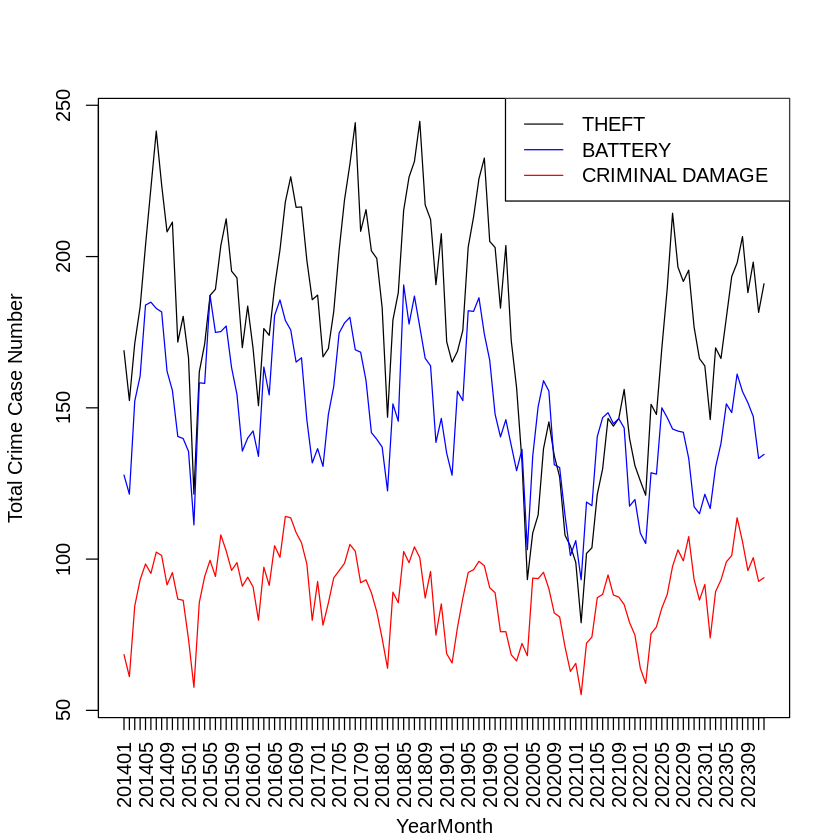

In [ ]:
mean_crime_matrix1 <- rowMeans(theft_matrix)
mean_crime_matrix2 <- rowMeans(battery_matrix)
mean_crime_matrix3 <- rowMeans(criminal_matrix)

colors <- c("black", "blue", "red")
mean_crime_matrices <- cbind(mean_crime_matrix1, mean_crime_matrix2, mean_crime_matrix3)

matplot(mean_crime_matrices, type="l", xlab="", ylab="Total Crime Case Number", xaxt="n", lty=1, col=colors)

at_positions <- seq_along(mean_crime_matrix1)
axis(1, at=at_positions, labels=year_month_labels, las=2)

mtext("YearMonth", side=1, line=4)

legend("topright", legend=c("THEFT", "BATTERY", "CRIMINAL DAMAGE"), lty=1, col=colors)


# EDA-ST

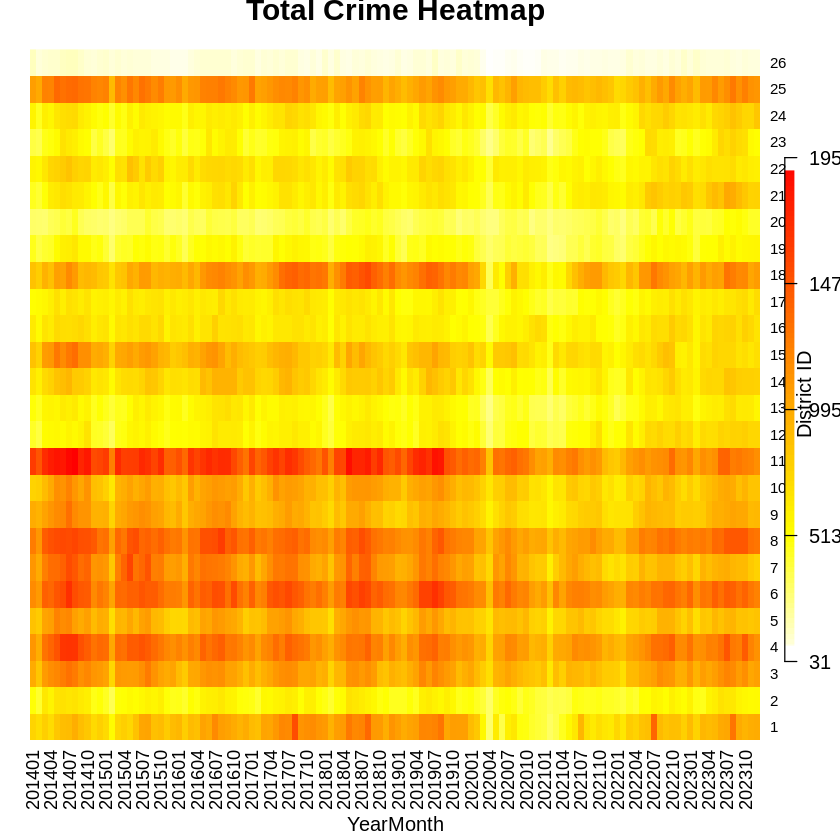

In [68]:
heatmap(transposed_crime_matrix, Rowv=NA, Colv=NA,
        col=rev(heat.colors(256)),
        scale="none",
        margins=c(5,3),
        xlab="YearMonth",
        ylab="District ID",
        main="Total Crime Heatmap",
        cexCol=1.1,
        labRow=district_labels,
        labCol=year_month_labels)

grad_width <- 0.2
grad_height <- 1.2
grad_len <- 100
gradient_matrix <- matrix(seq(0, 1, length.out = grad_len), nrow = grad_len, ncol = 1)

old_par <- par(no.readonly = TRUE)

par(mar=c(5, 4, 4, 2) + 0.1, oma=c(0, 0, 0, grad_width))

layout(matrix(c(1,2), nrow=1, byrow=TRUE), widths=c(1, grad_width), respect=TRUE)
image(1, seq(0, 1, length.out = grad_len), t(gradient_matrix),
      col=rev(heat.colors(256)),
      axes=FALSE,
      xlab="",
      ylab="",
      add=TRUE)

axis(4, at=seq(0, 1, length.out = 5),
     labels=seq(min(transposed_crime_matrix, na.rm = TRUE),
                max(transposed_crime_matrix, na.rm = TRUE),
                length.out = 5),
     las=1)

par(old_par)

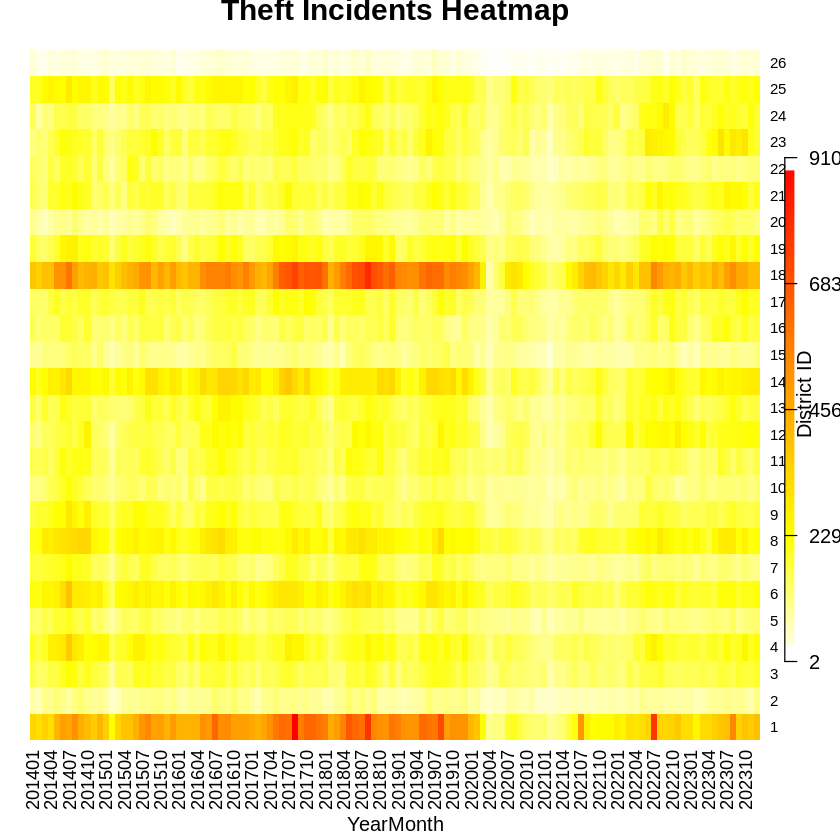

In [67]:
heatmap(transposed_theft_matrix, Rowv=NA, Colv=NA,
        col=rev(heat.colors(256)),
        scale="none",
        margins=c(5,3),
        xlab="YearMonth",
        ylab="District ID",
        main="Theft Incidents Heatmap",
        cexCol=1.1,
        labRow=district_labels,
        labCol=year_month_labels)
grad_width <- 0.2
grad_height <- 1
grad_len <- 100
gradient_matrix <- matrix(seq(0, 1, length.out = grad_len), nrow = grad_len, ncol = 1)

old_par <- par(no.readonly = TRUE)

par(mar=c(5, 4, 4, 2) + 0.1, oma=c(0, 0, 0, grad_width))

layout(matrix(c(1,2), nrow=1, byrow=TRUE), widths=c(1, grad_width), respect=TRUE)
image(1, seq(0, 1, length.out = grad_len), t(gradient_matrix),
      col=rev(heat.colors(256)),
      axes=FALSE,
      xlab="",
      ylab="",
      add=TRUE)

axis(4, at=seq(0, 1, length.out = 5),
     labels=seq(min(transposed_theft_matrix, na.rm = TRUE),
                max(transposed_theft_matrix, na.rm = TRUE),
                length.out = 5),
     las=1)
par(old_par)

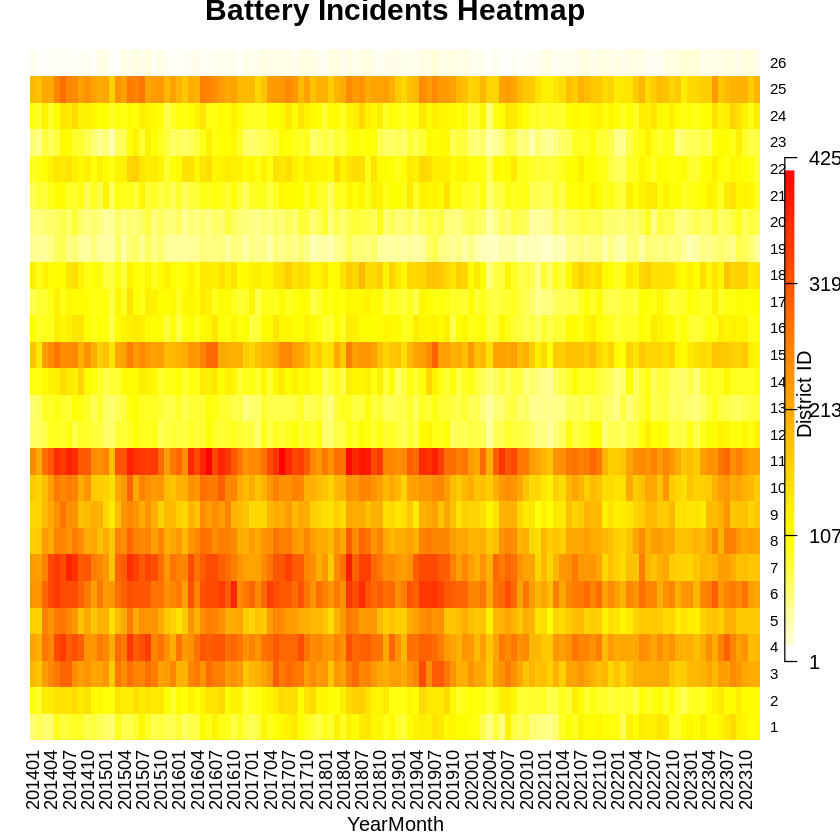

In [71]:
heatmap(transposed_battery_matrix, Rowv=NA, Colv=NA,
        col=rev(heat.colors(256)),
        scale="none",
        margins=c(5,3),
        xlab="YearMonth",
        ylab="District ID",
        main= "Battery Incidents Heatmap",
        cexCol=1.1,
        labRow=district_labels,
        labCol=year_month_labels)

grad_width <- 0.2
grad_height <- 1
gradient_matrix <- matrix(seq(0, 1, length.out = grad_len), nrow = grad_len, ncol = 1)

old_par <- par(no.readonly = TRUE)

par(mar=c(5, 4, 4, 2) + 0.1, oma=c(0, 0, 0, grad_width))

layout(matrix(c(1,2), nrow=1, byrow=TRUE), widths=c(1, grad_width), respect=TRUE)
image(1, seq(0, 1, length.out = grad_len), t(gradient_matrix),
      col=rev(heat.colors(256)),
      axes=FALSE,
      xlab="",
      ylab="",
      add=TRUE)

axis(4, at=seq(0, 1, length.out = 5),
     labels=seq(min(transposed_battery_matrix, na.rm = TRUE),
                max(transposed_battery_matrix, na.rm = TRUE),
                length.out = 5),
     las=1)

par(old_par)

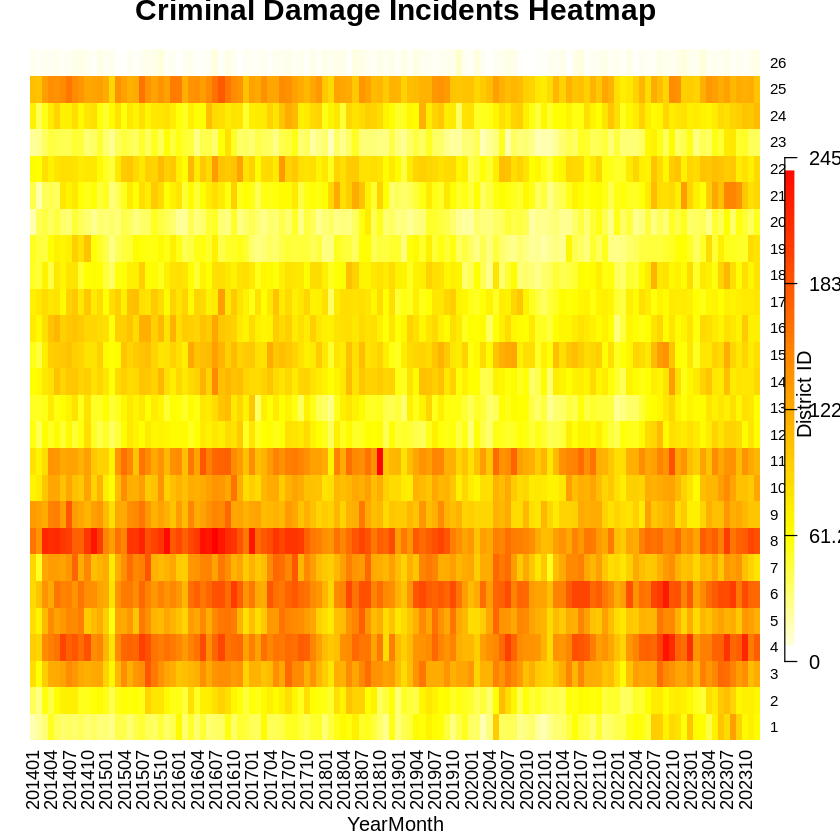

In [73]:
heatmap(transposed_criminal_matrix, Rowv=NA, Colv=NA,
        col=rev(heat.colors(256)),
        scale="none",
        margins=c(5,3),
        xlab="YearMonth",
        ylab="District ID",
        main="Criminal Damage Incidents Heatmap",
        cexCol=1.1,
        labRow=district_labels,
        labCol=year_month_labels)

grad_width <- 0.2
grad_height <- 1
grad_len <- 100
gradient_matrix <- matrix(seq(0, 1, length.out = grad_len), nrow = grad_len, ncol = 1)

old_par <- par(no.readonly = TRUE)

par(mar=c(5, 4, 4, 2) + 0.1, oma=c(0, 0, 0, grad_width))

layout(matrix(c(1,2), nrow=1, byrow=TRUE), widths=c(1, grad_width), respect=TRUE)
image(1, seq(0, 1, length.out = grad_len), t(gradient_matrix),
      col=rev(heat.colors(256)),
      axes=FALSE,
      xlab="",
      ylab="",
      add=TRUE)

axis(4, at=seq(0, 1, length.out = 5),
     labels=seq(min(transposed_criminal_matrix, na.rm = TRUE),
                max(transposed_criminal_matrix, na.rm = TRUE),
                length.out = 5),
     las=1)

par(old_par)

# ST-ARIMA

In [9]:
theft_mat2 <- theft_matrix[, -26]
battery_mat2 <- battery_matrix[, -26]
criminal_mat2 <- criminal_matrix[, -26]

In [10]:
# No neibours of OH
filtered_data <- chicago_district84[chicago_district84$DISTNO != 'OH', ]
nbrs <- poly2nb(filtered_data)
W1 <- nb2mat(nbrs)

In [11]:
Wlist <- nblag(nbrs, 3)
W2 <- nb2mat(Wlist[[2]])

0.755903236
0.664968121
0.569555359
0.421076945
0.266751449
0.180542639
0.097776978
0.120150706
0.156148071
0.260119225
0.351408719


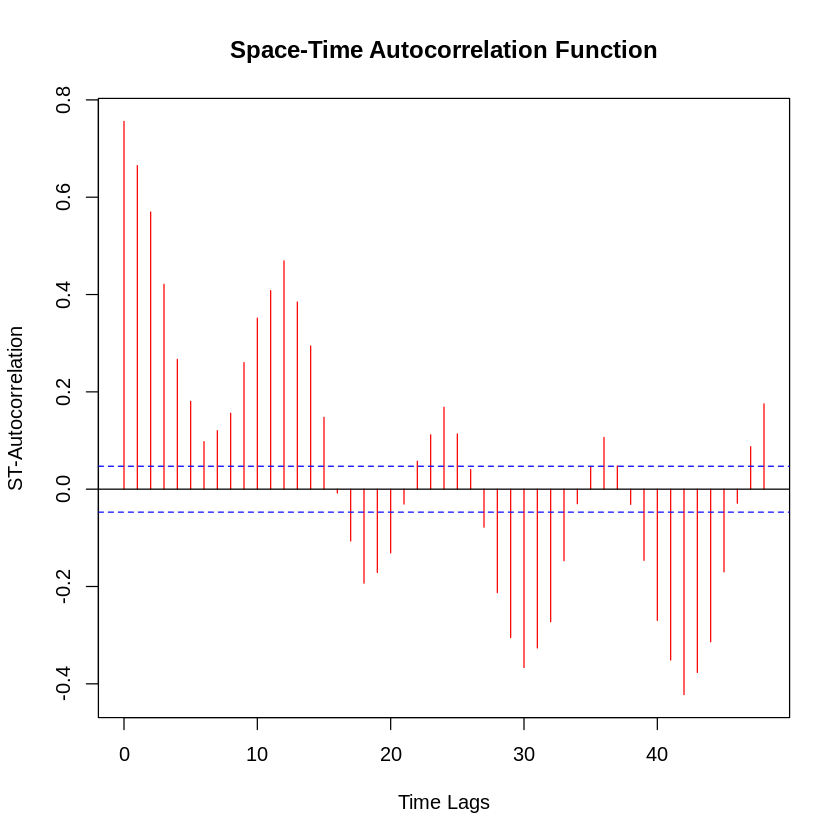

0.64048680
0.59328344
0.53591770
0.48086210
0.42971421
0.40498060
0.35398522
0.29881906
0.25006212
0.17947179
0.11327794


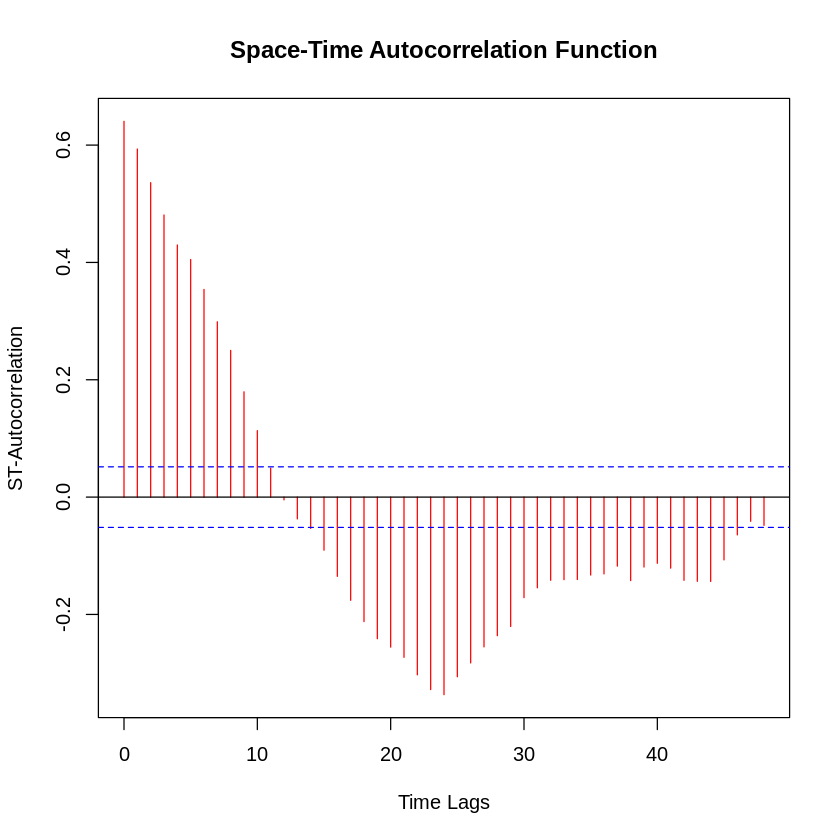

0.011245089
-0.098149437
-0.113903944
-0.047791358
0.070340605
0.008186718
0.091432547
0.030004748
0.060696351
0.010333334
-0.040312421


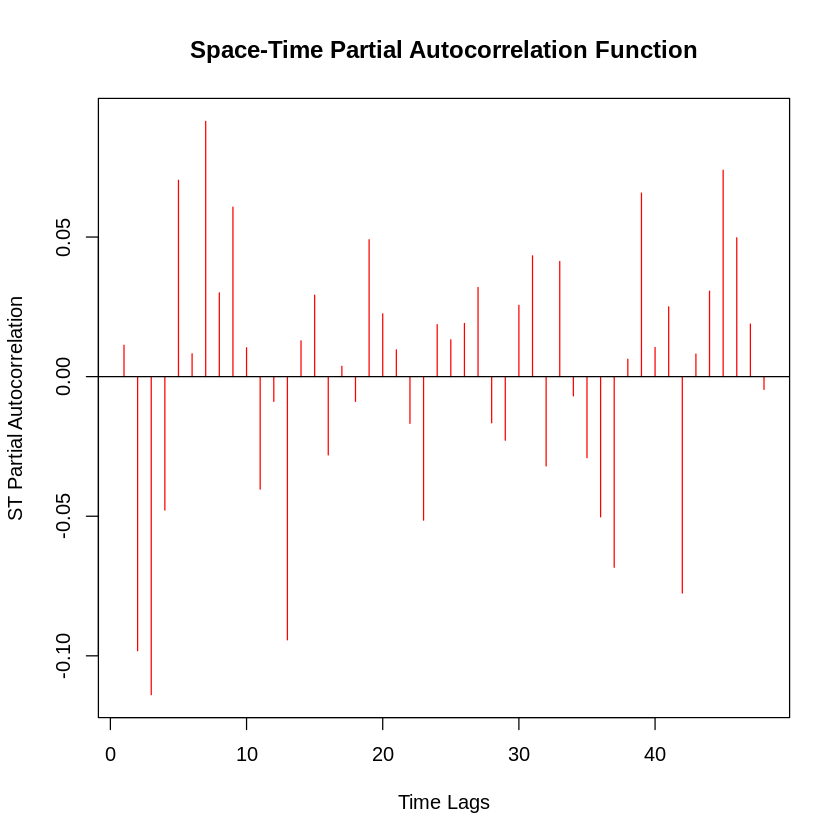

0.0698442076
-0.0590211710
-0.0579893837
-0.0148201963
0.0328511284
-0.0008227313
-0.0407474139
0.0043789028
-0.0097210342
0.0037422788
0.0312052767


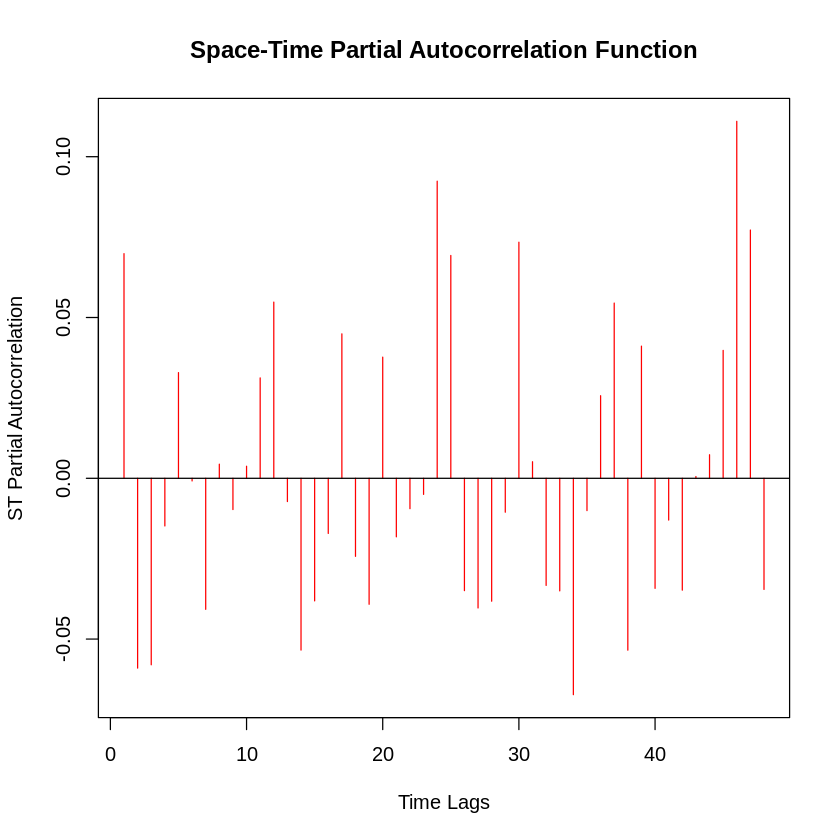

1.00000000
0.61454248
0.51825616
0.46443576
0.39138833
0.35900053
0.31147439
0.26946817
0.20968234
0.13273932
0.06069891


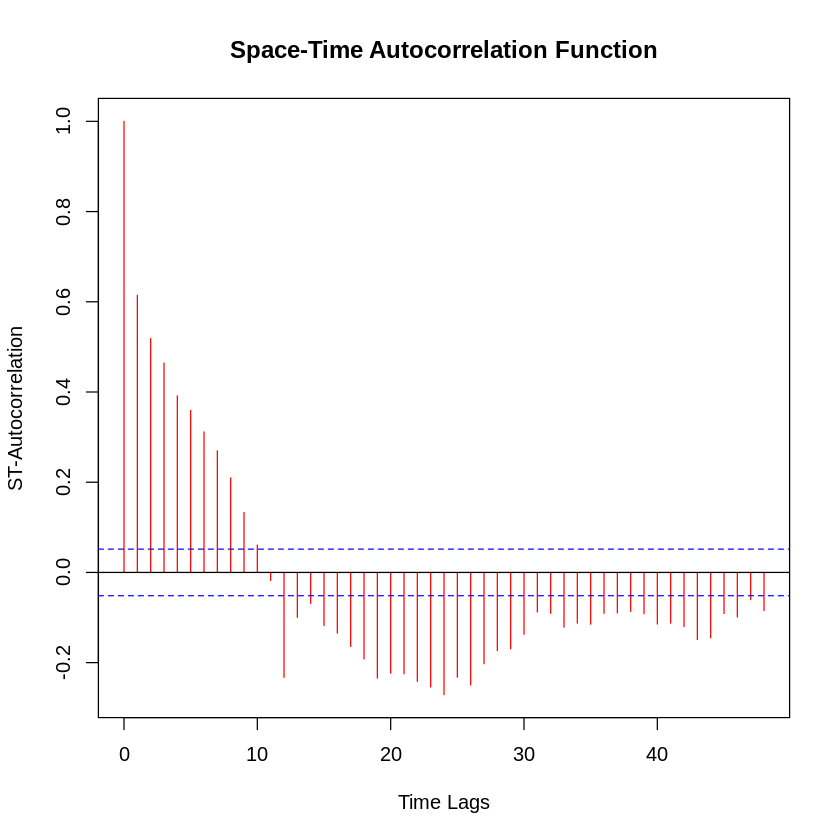

In [12]:
stacf(theft_mat2, W1, 48)
theft_mat2.diff <- diff(theft_mat2,lag=12,differences=1)
stacf(theft_mat2.diff, W1, 48)
stpacf(theft_mat2,W1,48)
stpacf(theft_mat2.diff,W1,48)

W0 <- diag(x=1, nrow(W1), ncol(W1))
stacf(theft_mat2.diff,W0,48)

In [28]:
W_fit<-list(w1=W1) # Create a list of spatial weight matrices, zero not needed
fit.star <- starima_fit(Z=theft_mat2[1:96,],W=W_fit,p=2,d=12,q=0)
Box.test(fit.star$RES[,6],lag=1, type="Ljung")



	Box-Ljung test

data:  fit.star$RES[, 6]
X-squared = 1.5738, df = 1, p-value = 0.2097


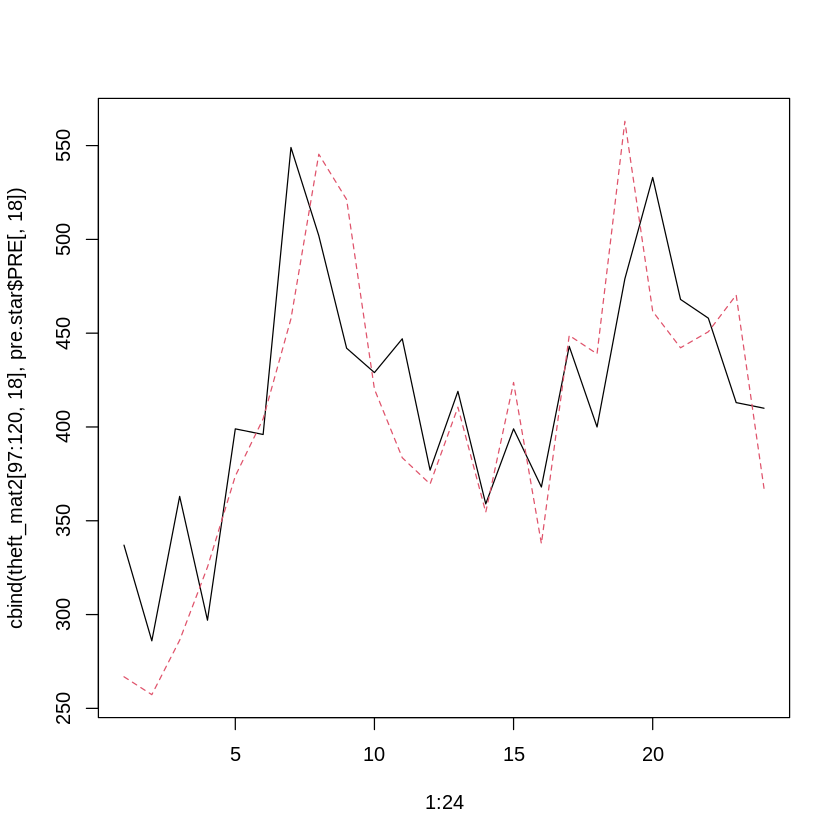

In [29]:
pre.star <- starima_pre(theft_mat2[(96-12-2+1):120,],
model=fit.star)
matplot(1:24,cbind(theft_mat2[97:120,18],pre.star$PRE[,18]),type="l")

0.282882889
0.019303972
0.031597326
-0.024585038
-0.056808070
0.039653055
0.038779270
-0.007073627
0.015817283
0.021766126
-0.050446388


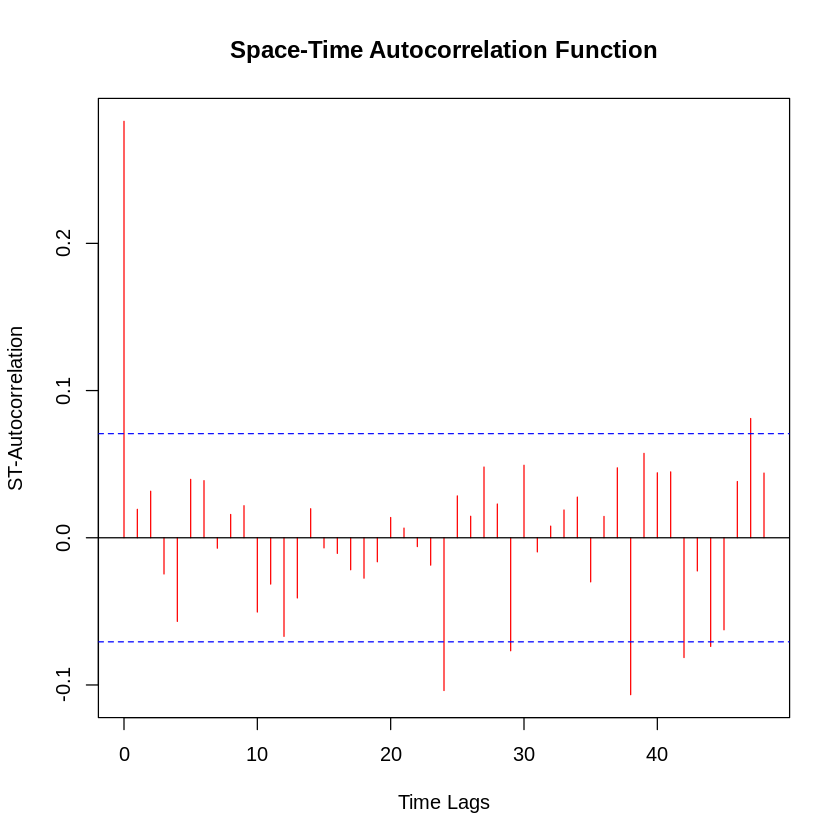

In [ ]:
stacf(fit.star$RES,W1,48)

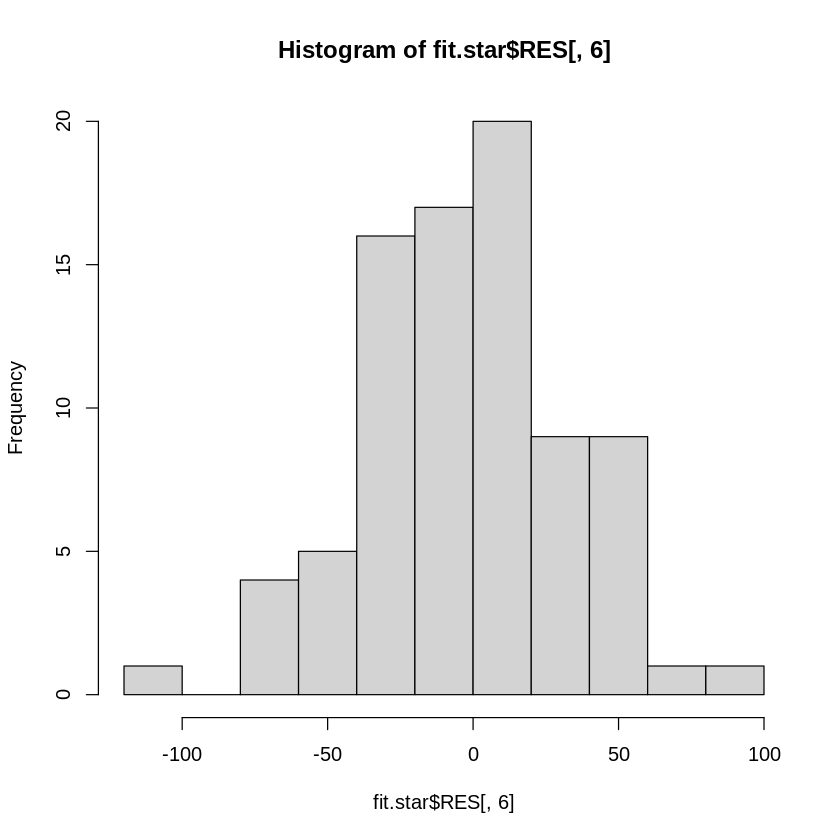

In [ ]:
hist(fit.star$RES[,6])

0.700027252
0.563083081
0.440907967
0.224539034
0.026409653
-0.078059337
-0.158383516
-0.097238851
0.006923143
0.177979532
0.357550800


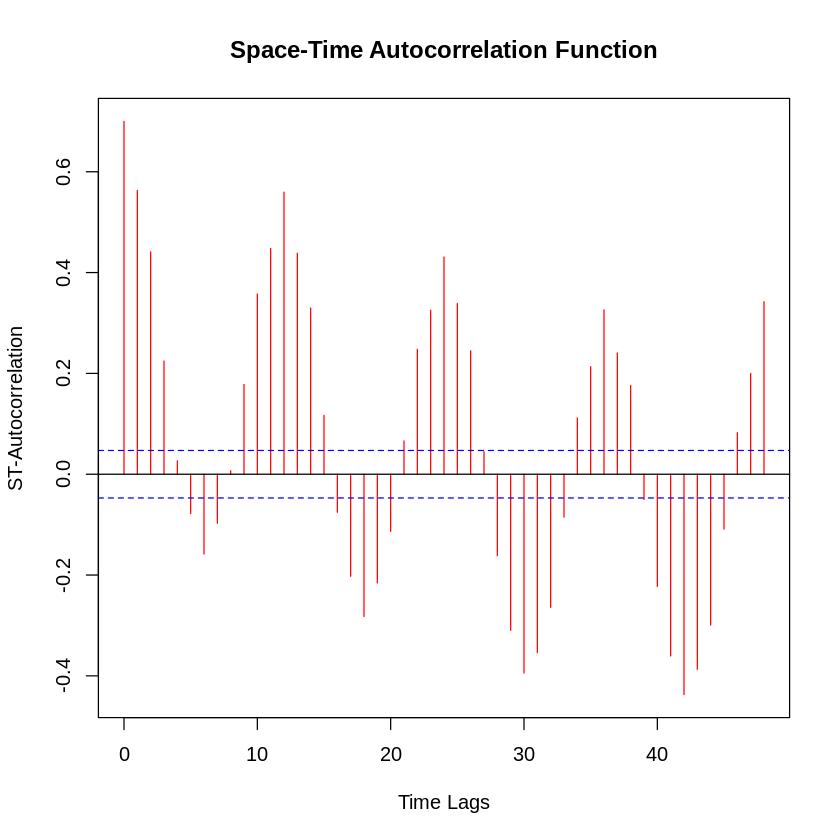

0.434099629
0.324694512
0.260733199
0.187515319
0.159679661
0.198238667
0.160034823
0.128750263
0.133605013
0.085680532
0.026935936


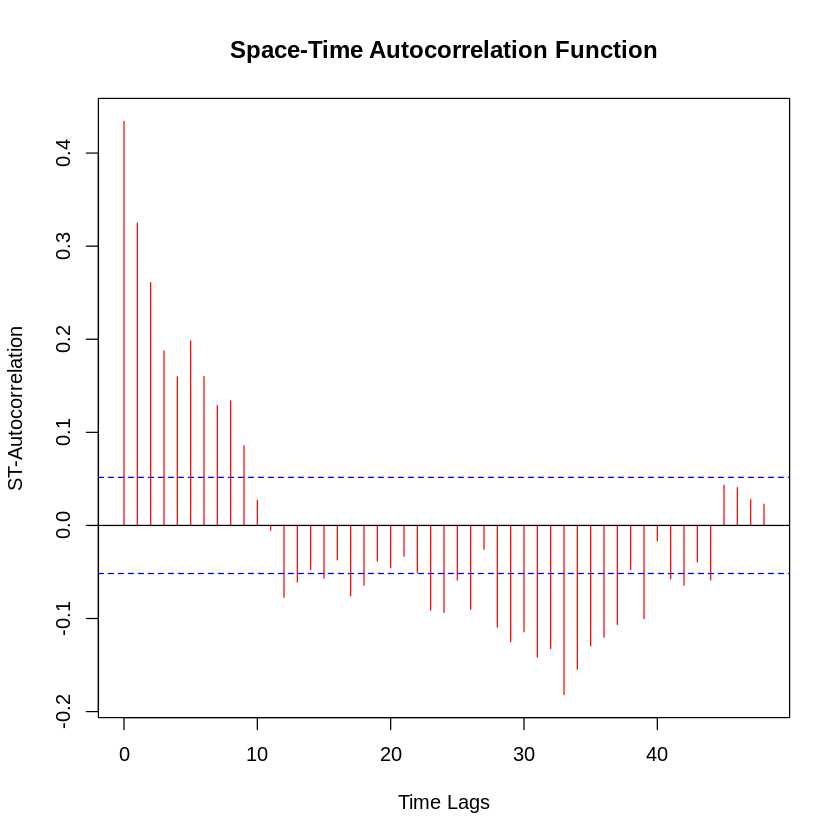

0.020099023
-0.188353817
-0.317545030
-0.046377501
0.191287373
0.052085096
0.148103425
0.076076486
0.035393620
0.085481303
-0.045431528


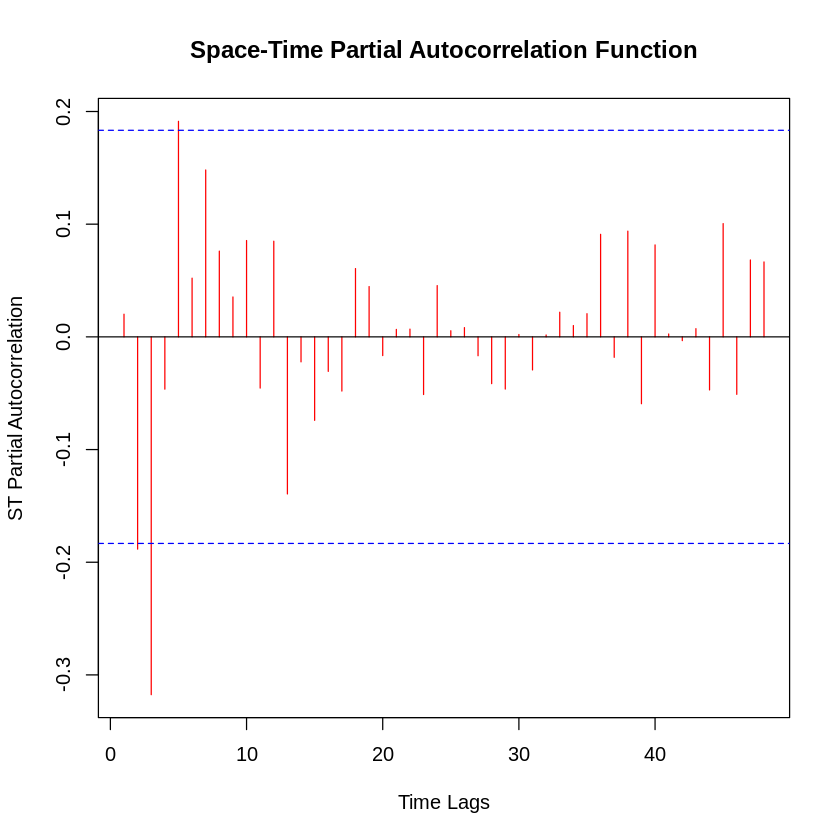

0.2244454307
0.0303466946
-0.0753586478
-0.0080092731
0.0878179304
-0.0288164459
-0.0102843033
0.0261144518
-0.0080248276
-0.0524296675
-0.0218096151


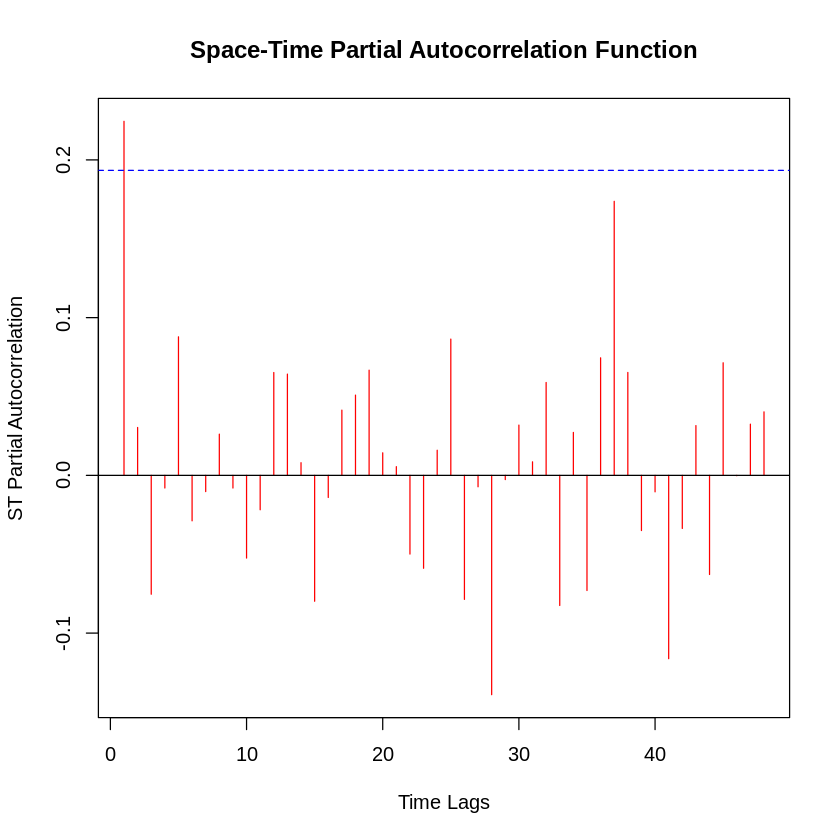

1.000000000
0.332393879
0.266766853
0.247703207
0.186088655
0.209212056
0.177729243
0.142521718
0.128266274
0.061486339
0.018133348


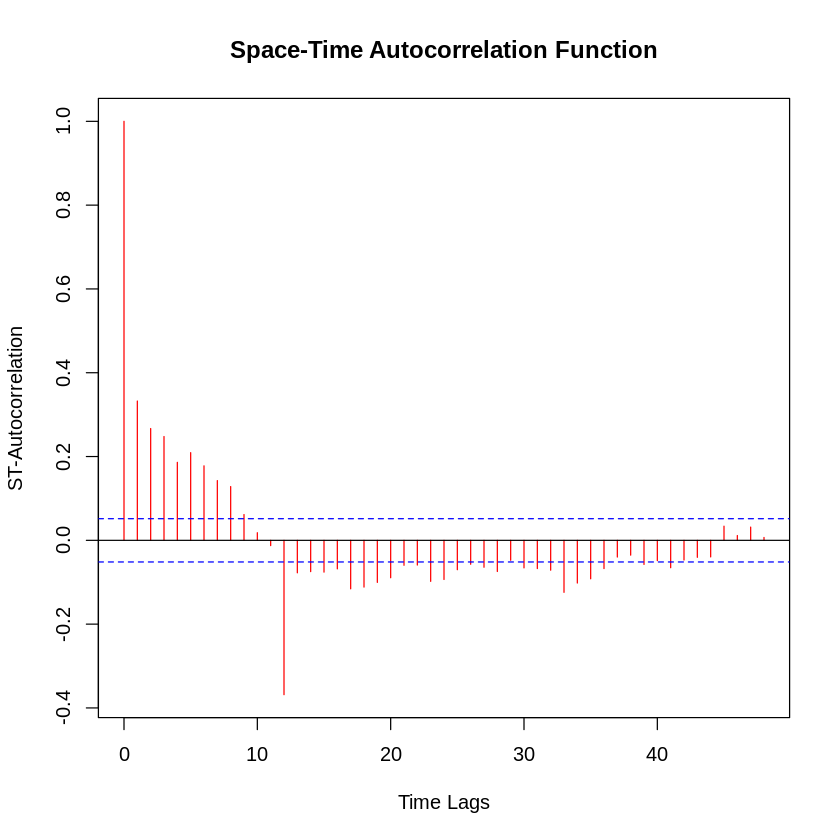

In [ ]:
stacf(battery_mat2, W1, 48)
battery_mat2.diff <- diff(battery_mat2,lag=12,differences=1)
stacf(battery_mat2.diff, W1, 48)
stpacf(battery_mat2,W1,48)
stpacf(battery_mat2.diff,W1,48)

W0 <- diag(x=1, nrow(W1), ncol(W1))
stacf(battery_mat2.diff,W0,48)

In [33]:
W_fit<-list(w1=W1)
fit.star <- starima_fit(Z=battery_mat2[1:96,],W=W_fit,p=3,d=12,q=1)
Box.test(fit.star$RES[,6],lag=1, type="Ljung")


	Box-Ljung test

data:  fit.star$RES[, 6]
X-squared = 0.32766, df = 1, p-value = 0.567


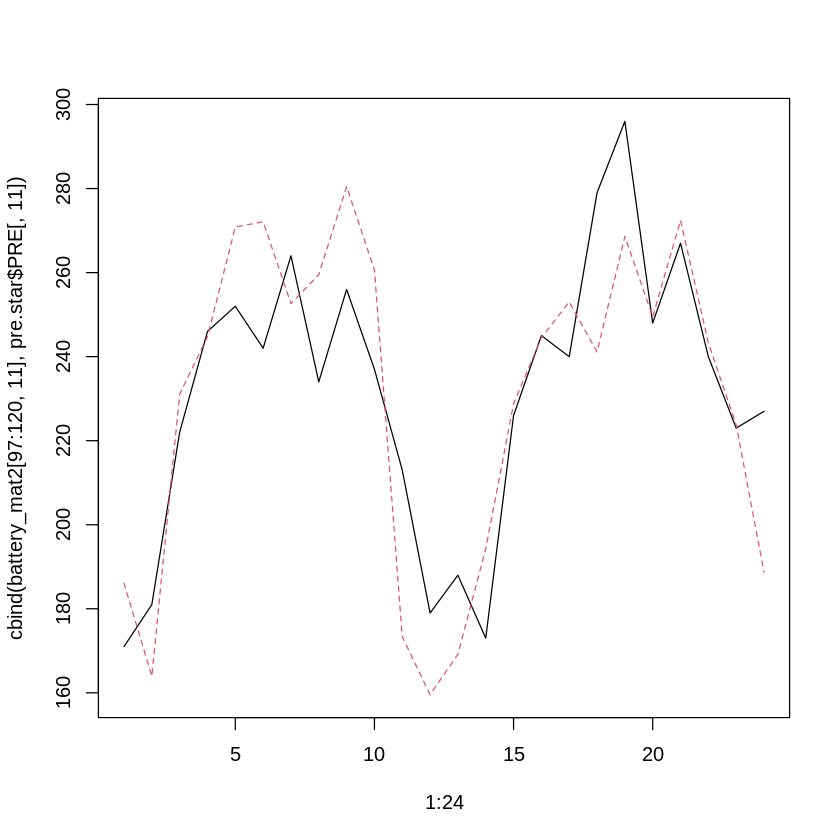

In [ ]:
pre.star <- starima_pre(battery_mat2[(96-12-4+1):120,],
model=fit.star)
matplot(1:24,cbind(battery_mat2[97:120,11],pre.star$PRE[,11]),type="l")

0.555762467
0.420967997
0.304970977
0.131174967
-0.025429609
-0.106835990
-0.183853900
-0.128277051
-0.046244876
0.095878622
0.241150845


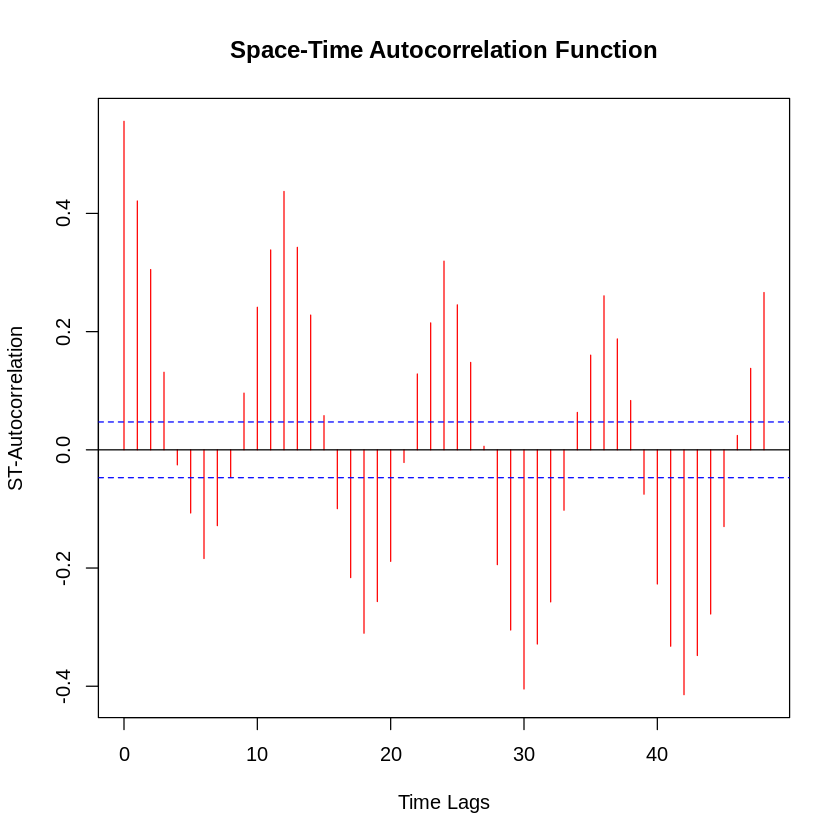

0.234099442
0.118599507
0.114633696
0.046337419
0.041827290
0.060258946
0.045266238
0.042132959
0.068218522
0.014126308
-0.026865810


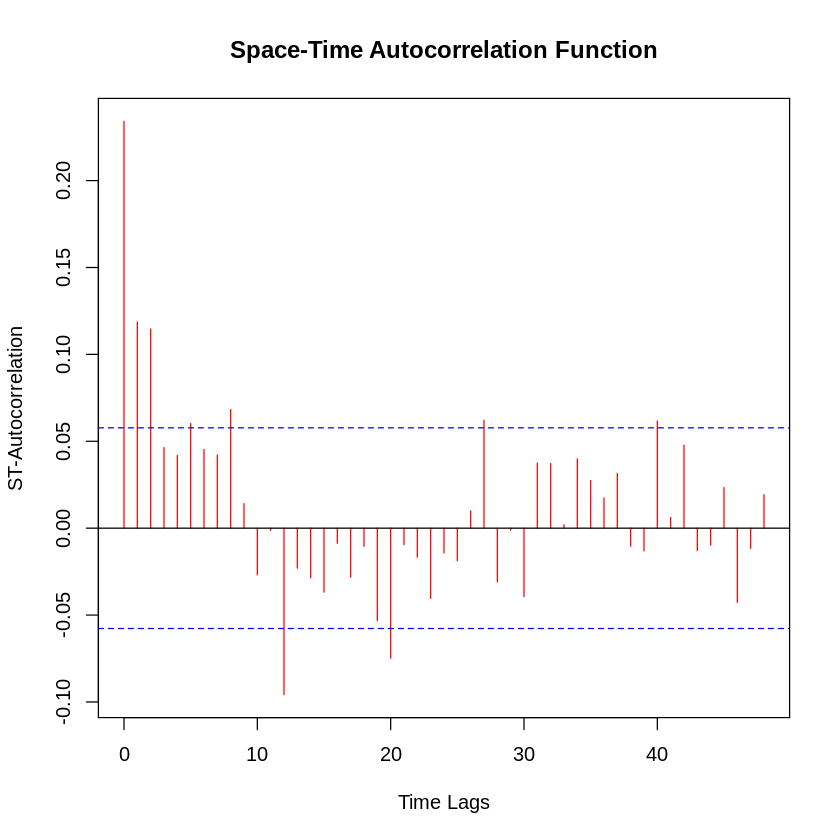

0.043967037
-0.124728693
-0.237331677
-0.130938686
0.063324205
0.016140432
0.139721911
0.080641153
0.085662361
0.075104233
0.007868894


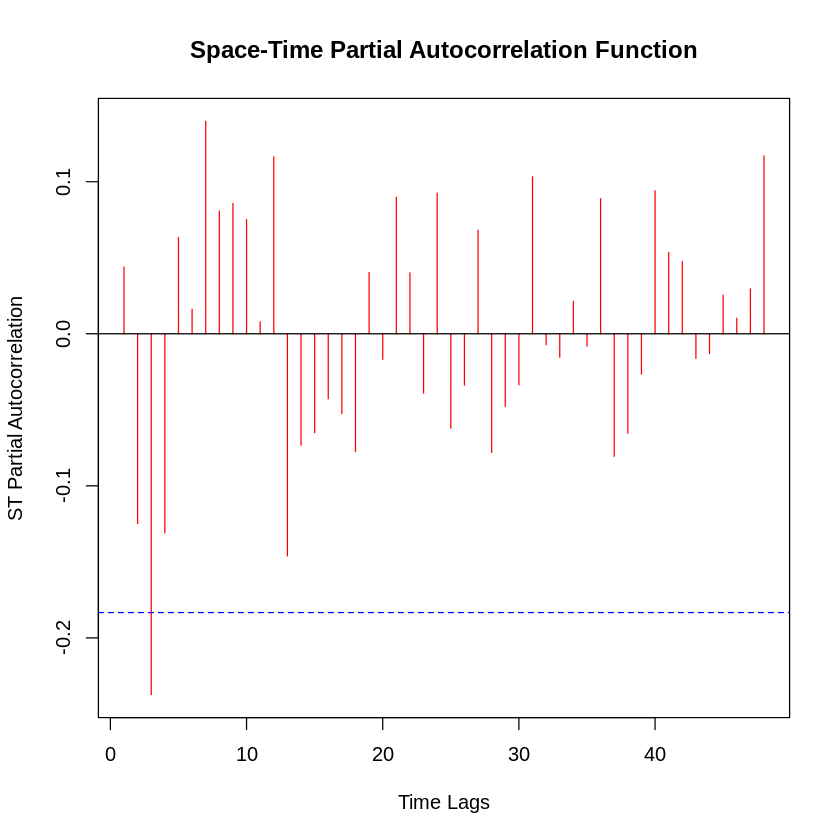

0.102298557
0.081209797
-0.035507380
-0.041658710
0.049094550
0.004162197
0.007890164
0.081522592
-0.052466910
-0.081121512
0.016557611


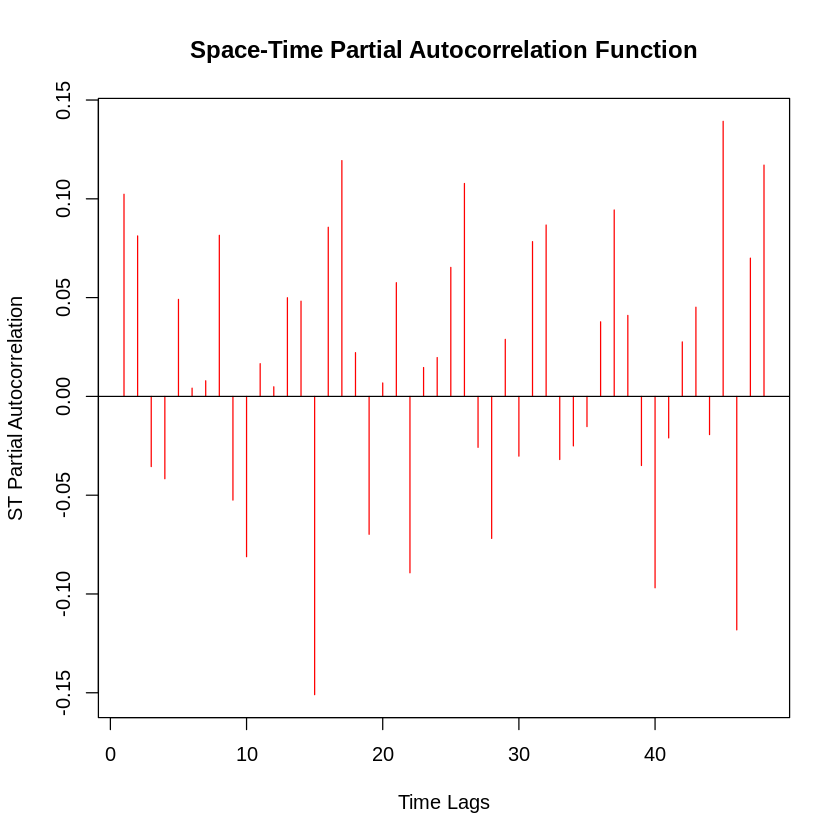

1.000000000
0.201379420
0.147653182
0.114704612
0.125754736
0.041080768
0.054660586
0.044102979
-0.011162910
-0.019926360
-0.032683112


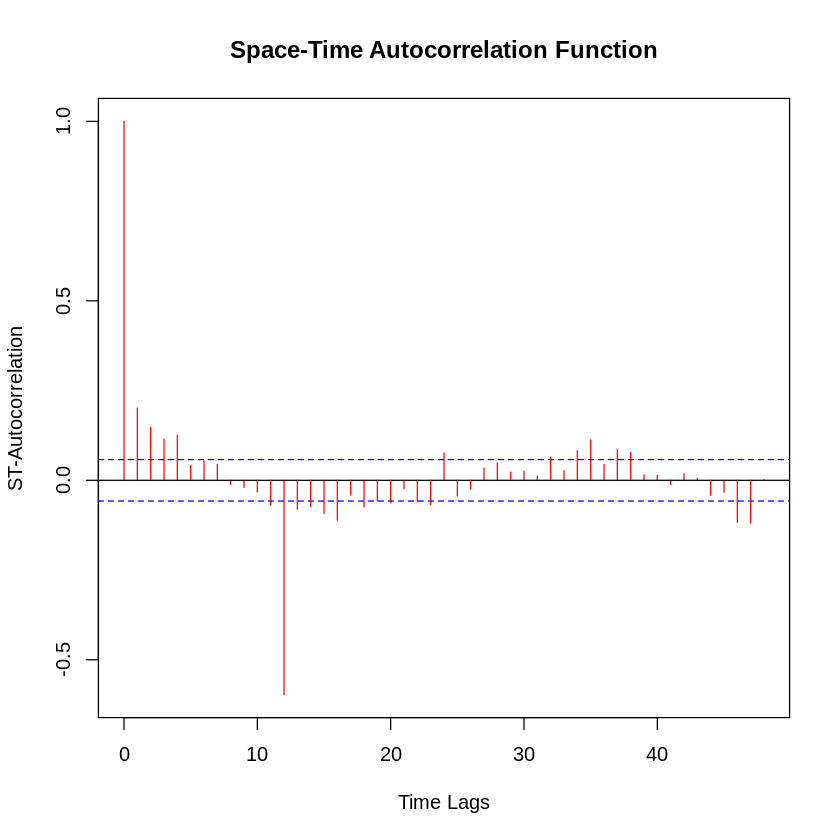

In [ ]:
stacf(criminal_mat2, W1, 48)
criminal_mat2.diff <- diff(criminal_mat2,lag=12,differences=2)
stacf(criminal_mat2.diff, W1, 48)
stpacf(criminal_mat2,W1,48)
stpacf(criminal_mat2.diff,W1,48)

W0 <- diag(x=1, nrow(W1), ncol(W1))
stacf(criminal_mat2.diff,W0,48)

In [39]:
W_fit<-list(w1=W1) # Create a list of spatial weight matrices, zero not needed
fit.star <- starima_fit(Z=criminal_mat2[1:96,],W=W_fit,p=3,d=12,q=2)
Box.test(fit.star$RES[,6],lag=1, type="Ljung")


	Box-Ljung test

data:  fit.star$RES[, 6]
X-squared = 0.78239, df = 1, p-value = 0.3764


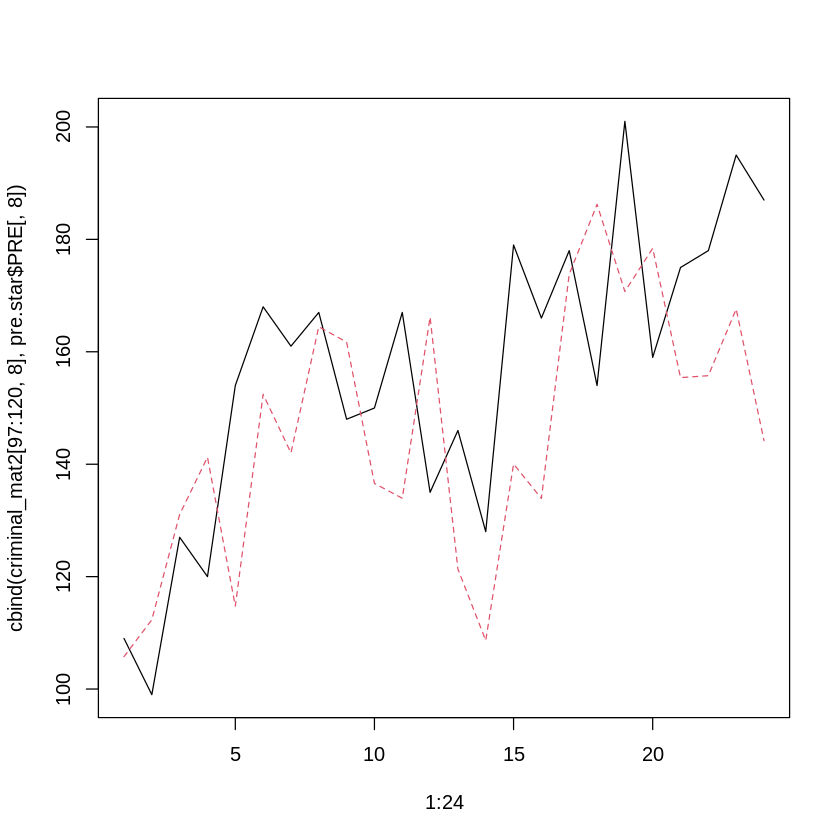

In [40]:
pre.star <- starima_pre(criminal_mat2[(96-12-5+1):120,],
model=fit.star)
matplot(1:24,cbind(criminal_mat2[97:120,8],pre.star$PRE[,8]),type="l")

In [43]:
test_data <- ts(criminal_mat2[(96-12-5+1):120,8])
rmse <- sqrt(mean(test_data-pre.star$PRE[,8])^2)
rmse

Warning message in `-.default`(test_data, pre.star$PRE[, 8]):
“longer object length is not a multiple of shorter object length”


[1] 6.397969

# Arima





theft - 18
battery - 11
criminal - 8




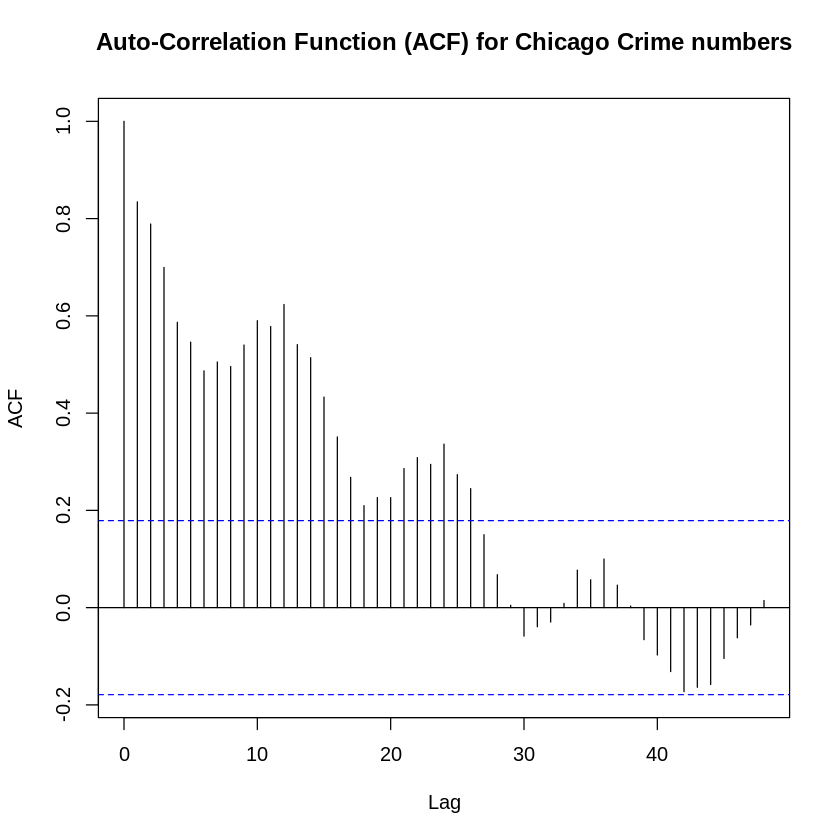

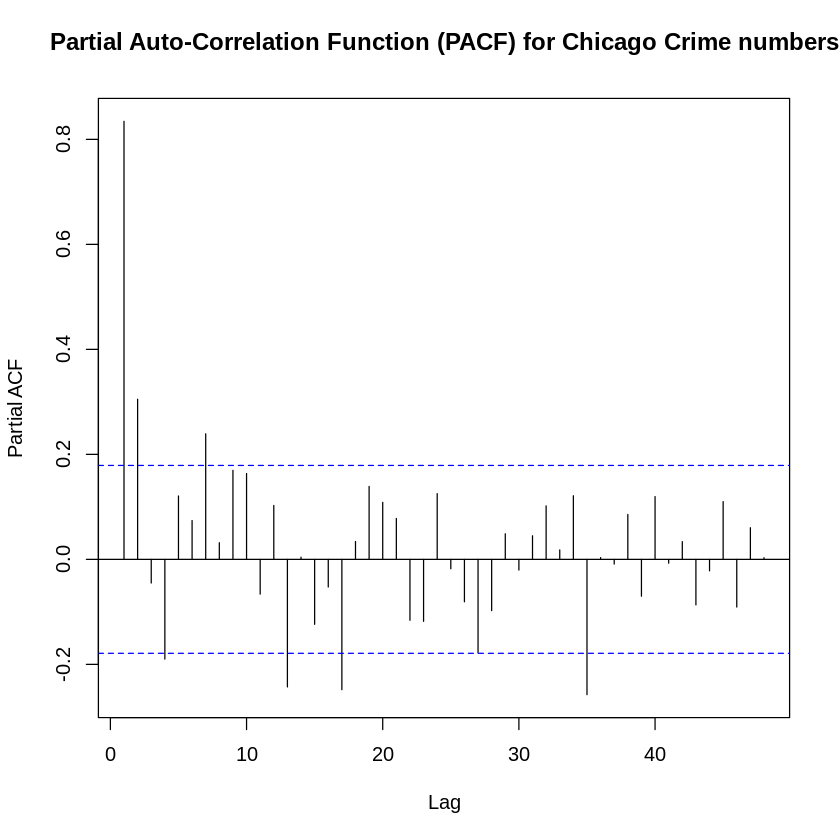

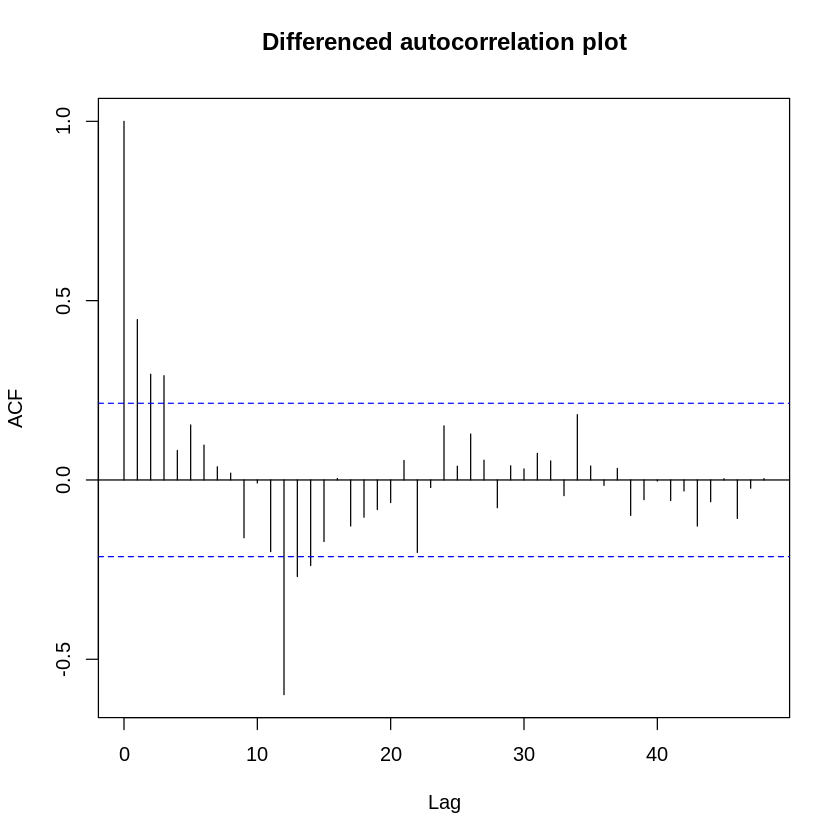

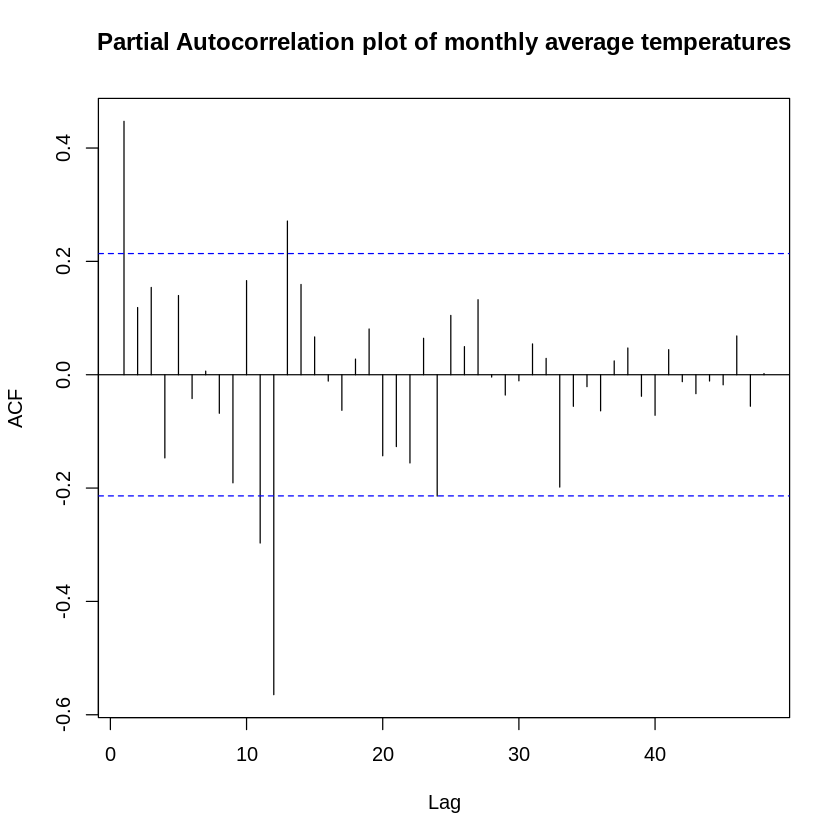

In [ ]:
crime_acf<-acf(transposed_crime_matrix[11,], lag.max=48, main="Auto-Correlation Function (ACF) for Chicago Crime numbers")
crime_pacf<-pacf(transposed_crime_matrix[11,], lag.max=48, main="Partial Auto-Correlation Function (PACF) for Chicago Crime numbers")
crime.s.diff <- diff(transposed_crime_matrix[11,], lag=12, differences=3)
crime_diff_acf<-acf(crime.s.diff, lag.max=48, xlab="Lag", ylab="ACF", main="Differenced autocorrelation plot")

crime_diff_pacf<-pacf(crime.s.diff, lag.max=48, xlab="Lag", ylab="ACF",main="Partial Autocorrelation plot of monthly average temperatures")

In [ ]:
print(crime_acf)
print(crime_pacf)
print(crime_diff_acf)
print(crime_diff_pacf)

In [ ]:
fit_arima <- arima(transposed_crime_matrix[11,1:96],order=c(1,0,2),seasonal=list(order =c(1,1,0),period=12))
fit_arima
NRMSE_fit <- NRMSE(res=fit_arima$residuals, obs=transposed_crime_matrix[11,1:96])
NRMSE_fit


Call:
arima(x = transposed_crime_matrix[11, 1:96], order = c(1, 0, 2), seasonal = list(order = c(1, 
    1, 0), period = 12))

Coefficients:
         ar1      ma1      ma2     sar1
      0.9703  -0.5003  -0.0732  -0.5166
s.e.  0.0313   0.1176   0.1151   0.0985

sigma^2 estimated as 16310:  log likelihood = -528.92,  aic = 1067.83

[1] 0.479086

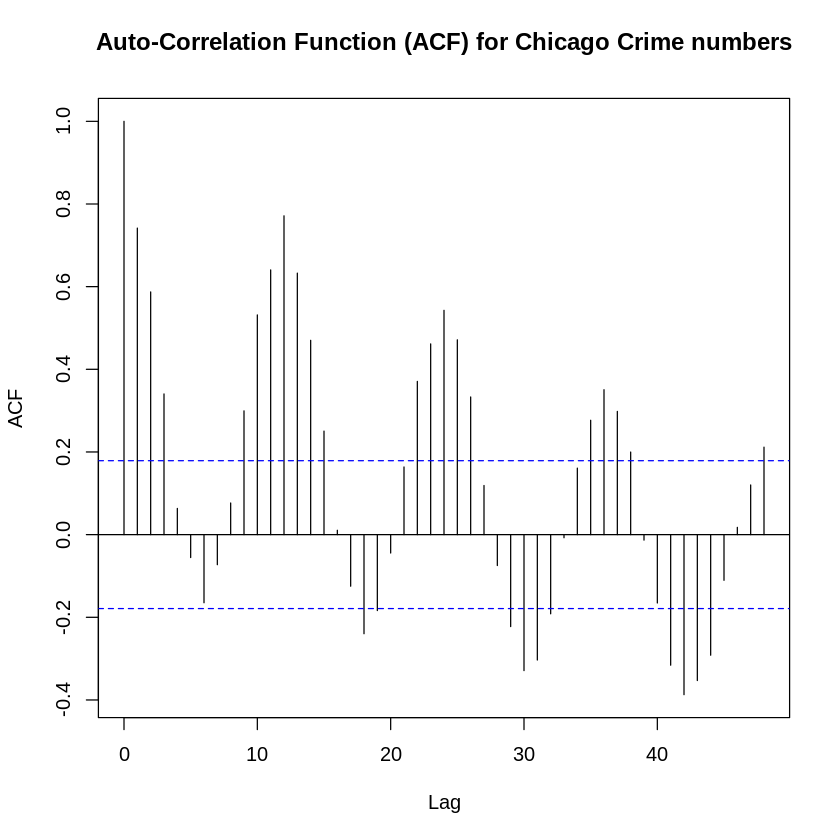

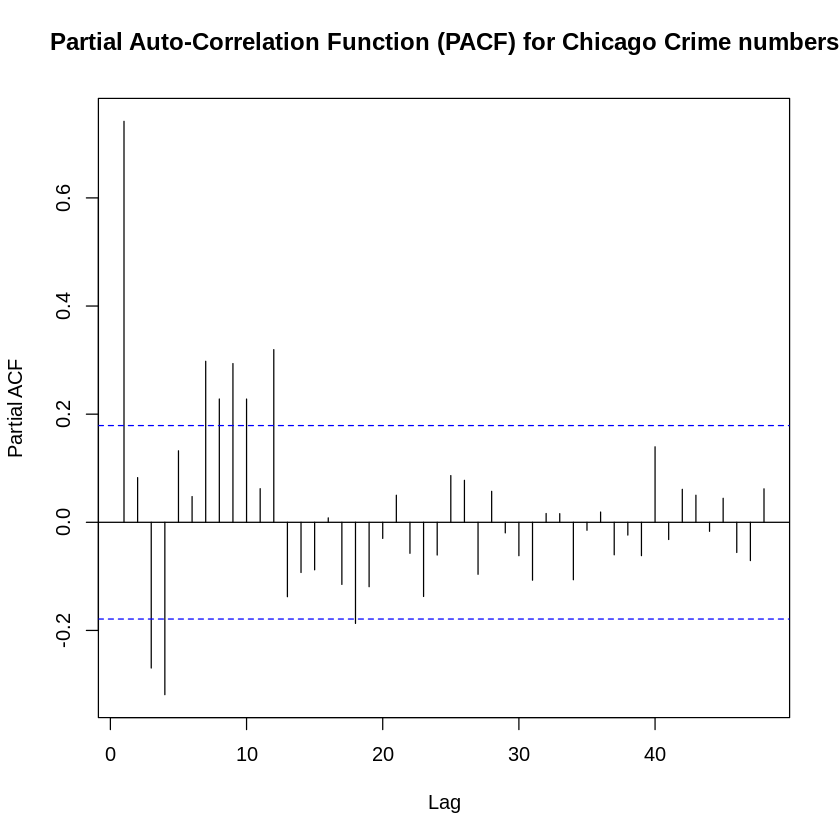

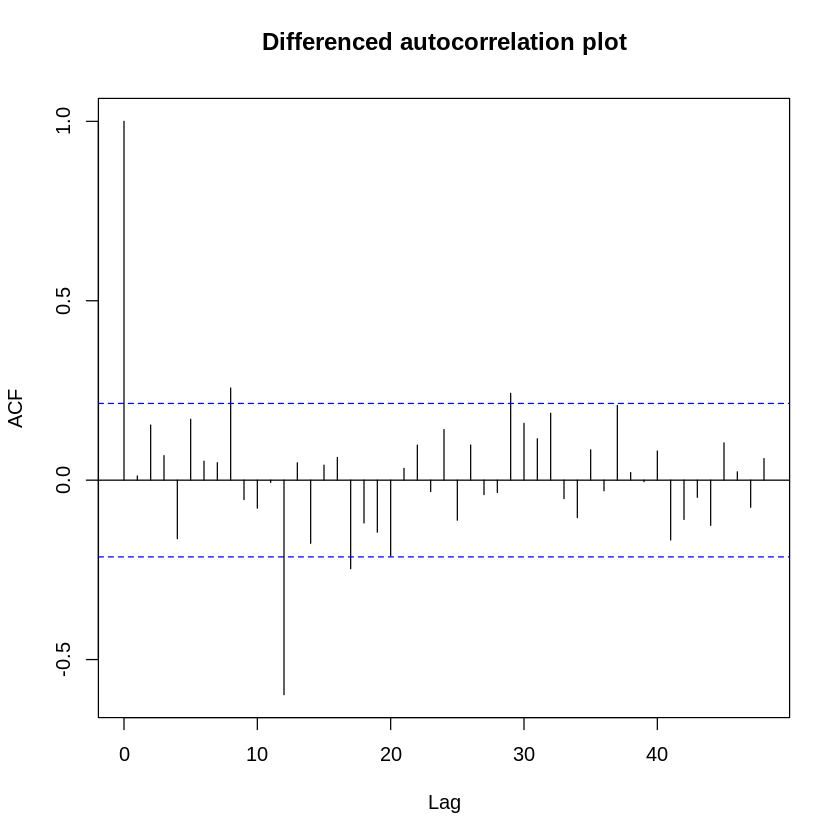

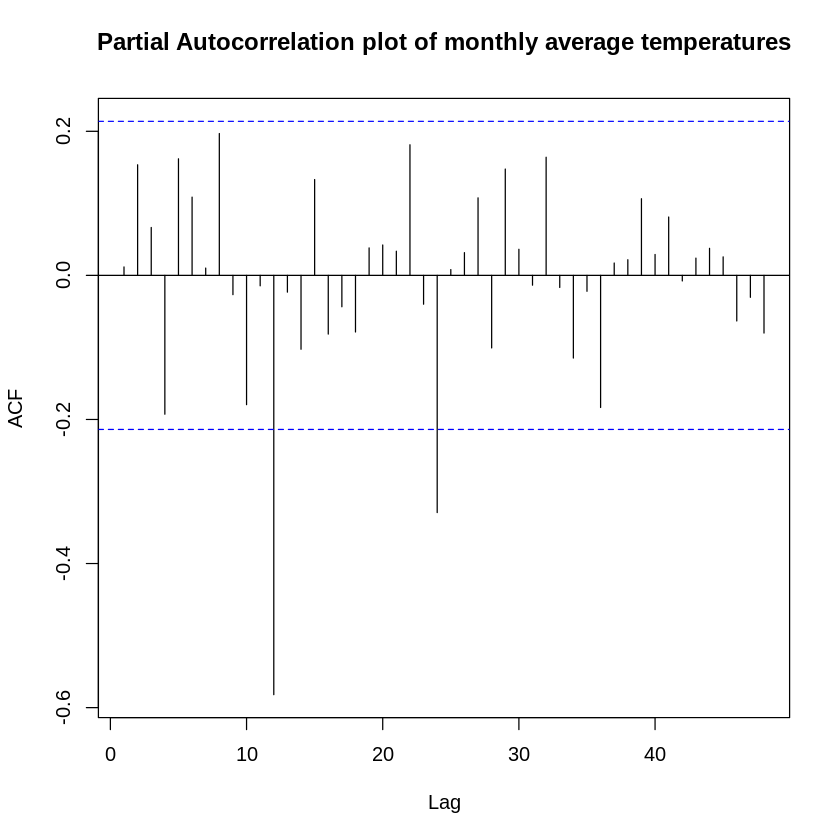

In [ ]:
battery_acf<-acf(transposed_battery_matrix[11,], lag.max=48, main="Auto-Correlation Function (ACF) for Chicago Crime numbers")
battery_pacf<-pacf(transposed_battery_matrix[11,], lag.max=48, main="Partial Auto-Correlation Function (PACF) for Chicago Crime numbers")
battery.s.diff <- diff(transposed_battery_matrix[11,], lag=12, differences=3)
battery_diff_acf<-acf(battery.s.diff, lag.max=48, xlab="Lag", ylab="ACF", main="Differenced autocorrelation plot")

battery_diff_pacf<-pacf(battery.s.diff, lag.max=48, xlab="Lag", ylab="ACF",main="Partial Autocorrelation plot of monthly average temperatures")

In [ ]:
print(battery_acf)
print(battery_pacf)
print(battery_diff_acf)
print(battery_diff_pacf)

In [ ]:
fit_arima <- arima(transposed_battery_matrix[11,1:96],order=c(1,1,2),seasonal=list(order =c(2,1,3),period=12))
fit_arima
NRMSE_fit <- NRMSE(res=fit_arima$residuals, obs=transposed_battery_matrix[11,1:96])
NRMSE_fit
residuals <- residuals(fit_arima)
box_test_result <- Box.test(residuals, type="Ljung-Box")
box_test_result


Call:
arima(x = transposed_battery_matrix[11, 1:96], order = c(1, 1, 2), seasonal = list(order = c(2, 
    1, 3), period = 12))

Coefficients:
          ar1     ma1      ma2     sar1     sar2    sma1     sma2     sma3
      -0.8788  0.2018  -0.7982  -0.9325  -0.6191  0.3198  -0.3200  -0.9996
s.e.   0.0616  0.1194   0.1034   0.6291   0.3359  0.8473   0.8491   0.5544

sigma^2 estimated as 502.9:  log likelihood = -396.13,  aic = 810.25

[1] 0.3535417


	Box-Ljung test

data:  residuals
X-squared = 0.15549, df = 1, p-value = 0.6933


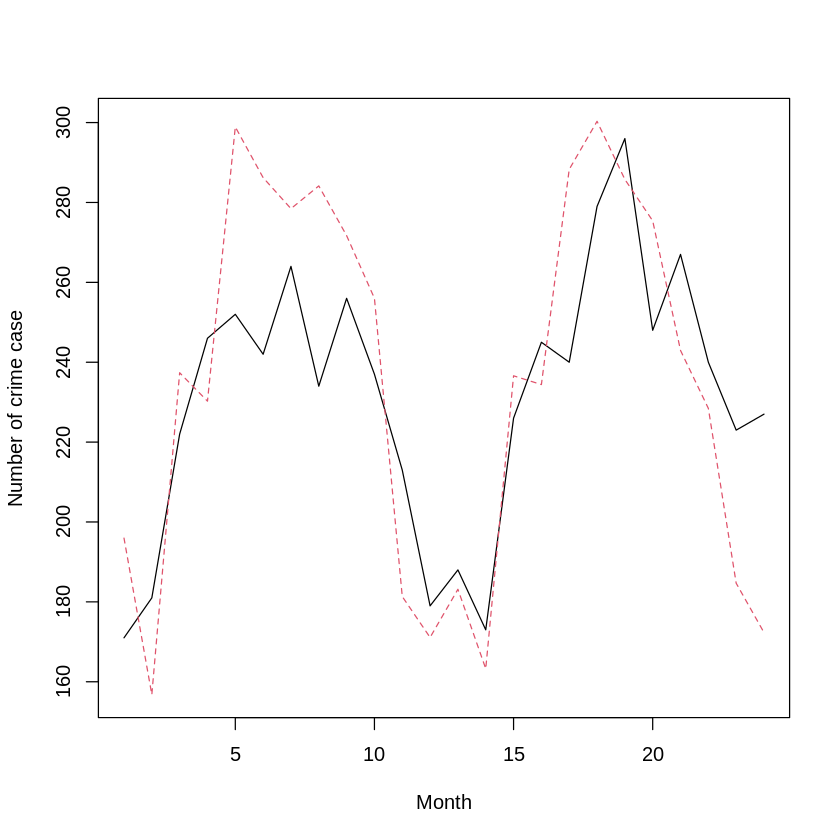

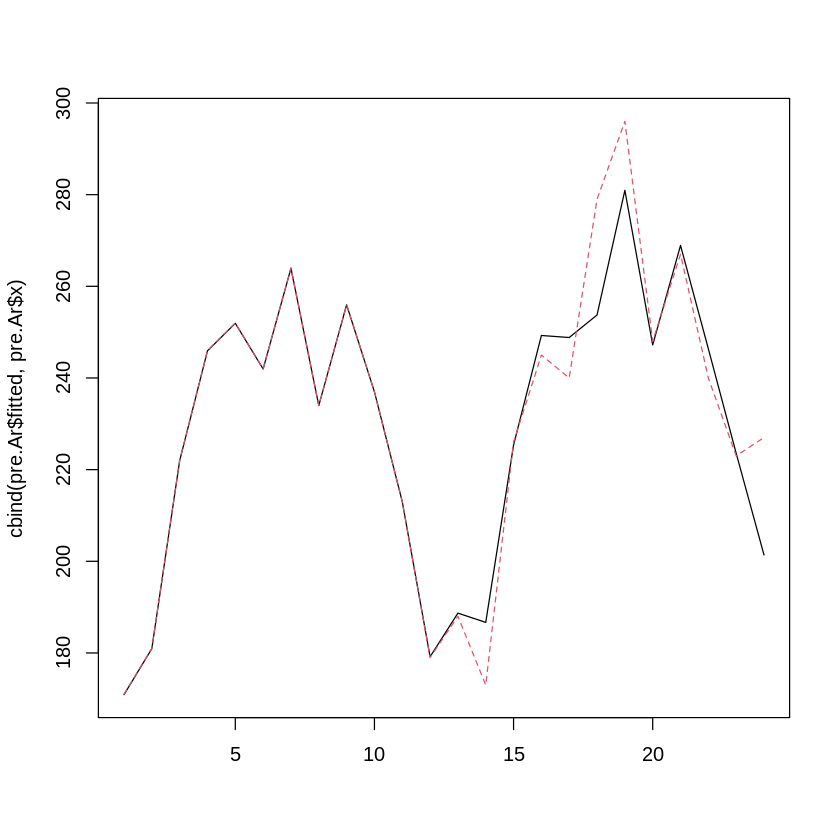

In [ ]:
pre_ar<-predict(fit_arima, n.ahead=24)
matplot(1:24,cbind(transposed_battery_matrix[11,97:120],pre_ar$pred),type="l",main="", xlab="Month", ylab="Number of crime case")
fit.Ar <- Arima(transposed_battery_matrix[11,1:96],order=c(1,1,2),seasonal=list(order =c(2,1,3),period=12))
pre.Ar <- Arima(transposed_battery_matrix[11, 97:(ncol(transposed_battery_matrix))], model=fit.Ar)
matplot(cbind(pre.Ar$fitted, pre.Ar$x), type="l")

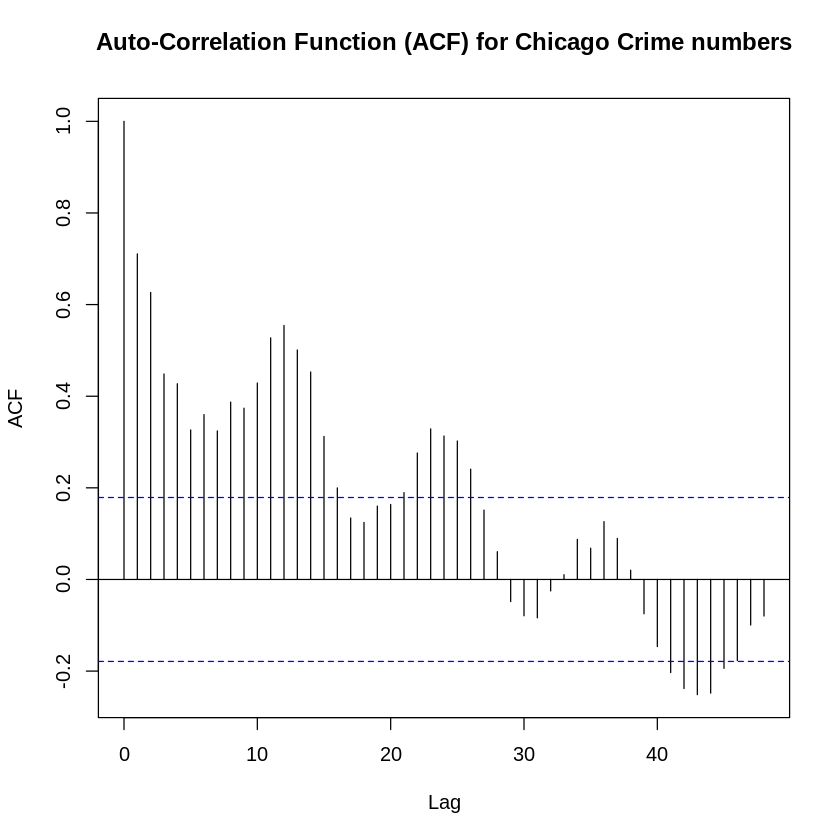

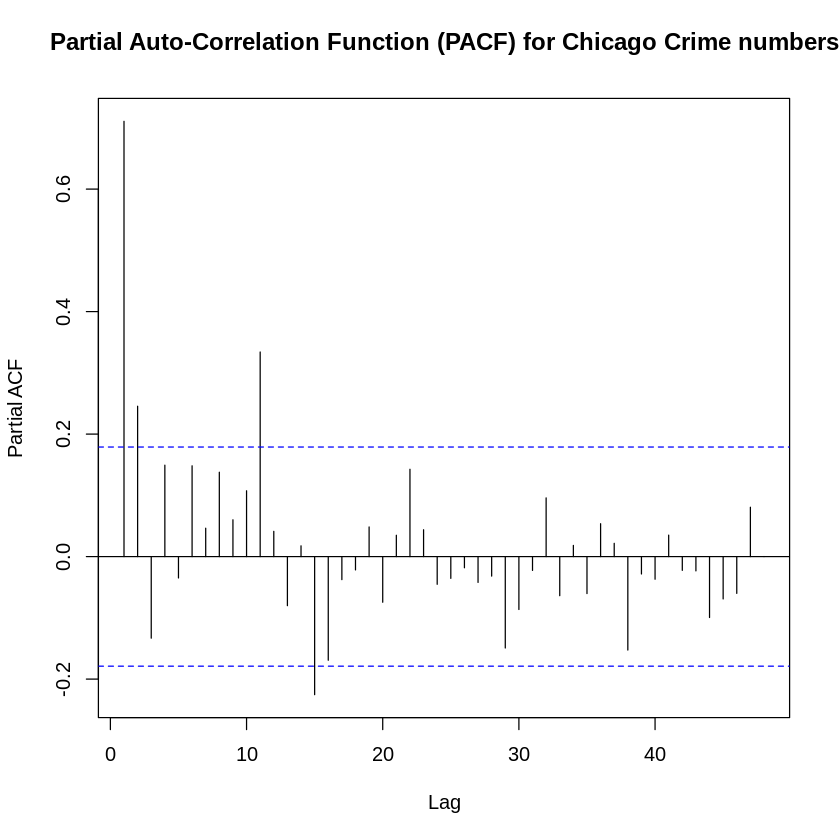

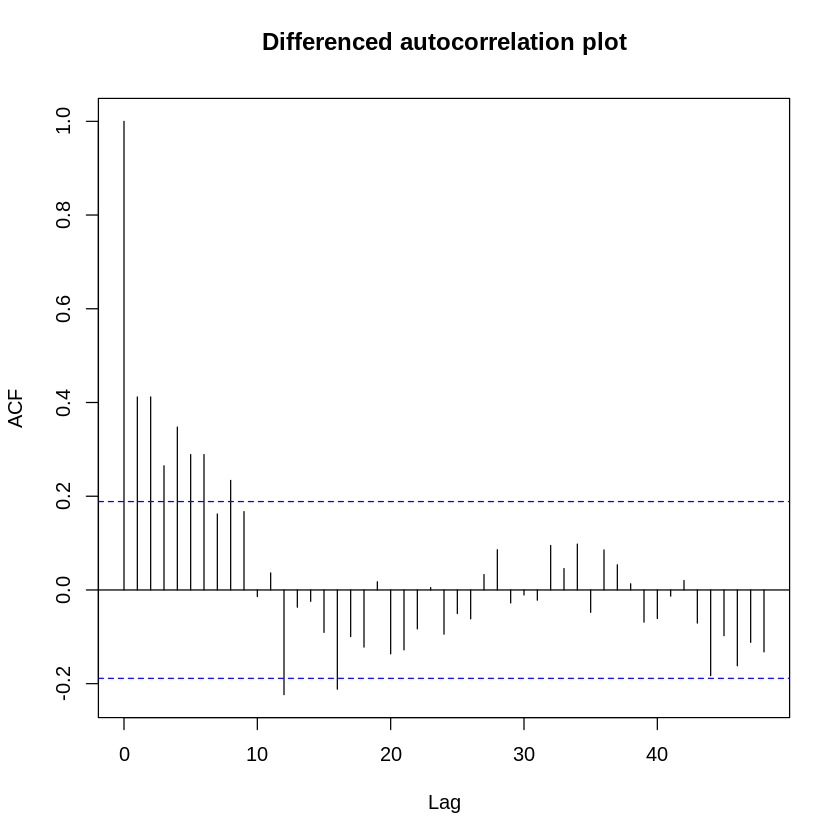

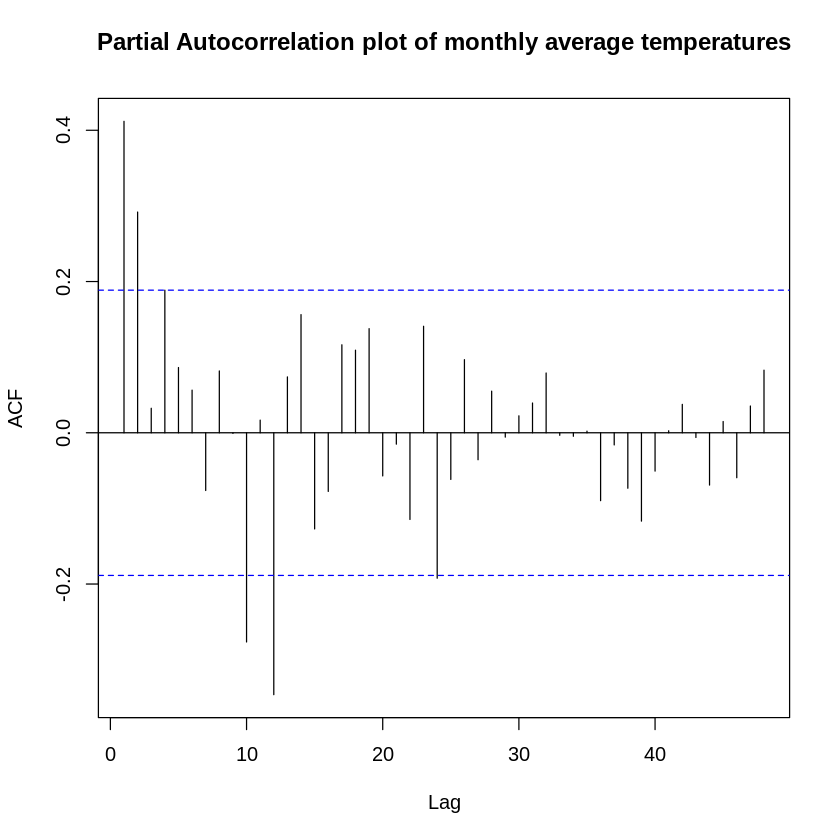

In [ ]:
criminal_acf<-acf(transposed_criminal_matrix[8,], lag.max=48, main="Auto-Correlation Function (ACF) for Chicago Crime numbers")
criminal_pacf<-pacf(transposed_criminal_matrix[8,], lag.max=48, main="Partial Auto-Correlation Function (PACF) for Chicago Crime numbers")
criminal.s.diff <- diff(transposed_criminal_matrix[8,], lag=12, differences=1)
criminal_diff_acf<-acf(criminal.s.diff, lag.max=48, xlab="Lag", ylab="ACF", main="Differenced autocorrelation plot")

criminal_diff_pacf<-pacf(criminal.s.diff, lag.max=48, xlab="Lag", ylab="ACF",main="Partial Autocorrelation plot of monthly average temperatures")

In [ ]:
print(criminal_acf)
print(criminal_pacf)
print(criminal_diff_acf)
print(criminal_diff_pacf)

In [ ]:
fit_arima <- arima(transposed_criminal_matrix[8,1:96],order=c(2,0,0),seasonal=list(order =c(2,1,3),period=12))
fit_arima
NRMSE_fit <- NRMSE(res=fit_arima$residuals, obs=transposed_criminal_matrix[8,1:96])
NRMSE_fit
residuals <- residuals(fit_arima)
box_test_result <- Box.test(residuals, type="Ljung-Box")
box_test_result


Call:
arima(x = transposed_criminal_matrix[8, 1:96], order = c(2, 0, 0), seasonal = list(order = c(2, 
    1, 3), period = 12))

Coefficients:
         ar1     ar2     sar1     sar2     sma1    sma2     sma3
      0.4526  0.2741  -0.1557  -0.9738  -0.3872  0.9915  -0.4045
s.e.  0.1102  0.1093   0.3418   0.0820   0.4080  0.8943   0.4312

sigma^2 estimated as 379.4:  log likelihood = -380.89,  aic = 777.79

[1] 0.5528


	Box-Ljung test

data:  residuals
X-squared = 0.31956, df = 1, p-value = 0.5719


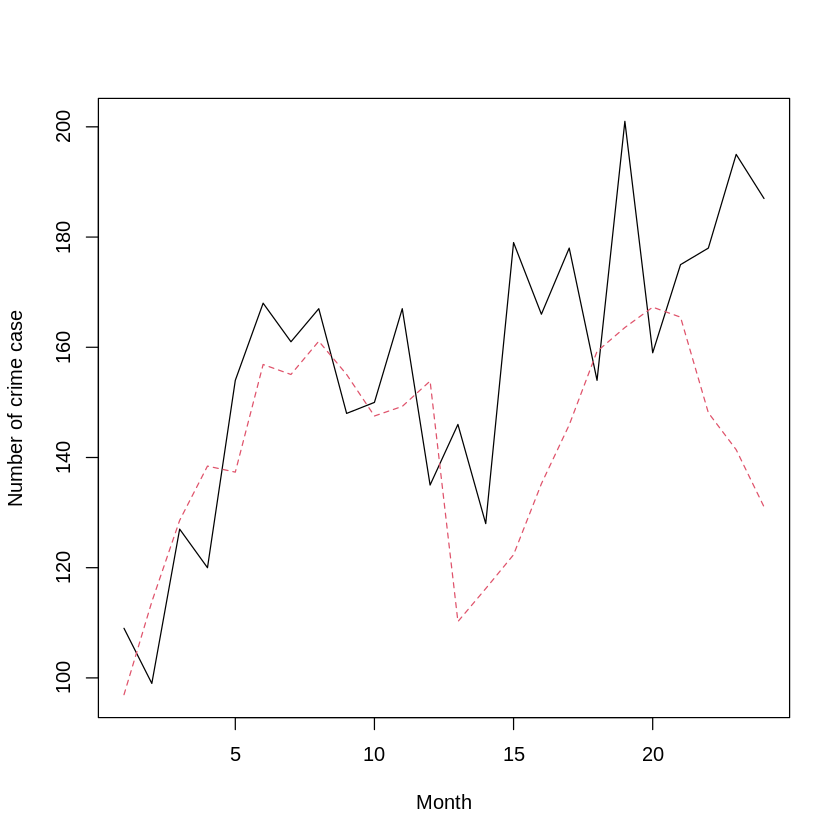

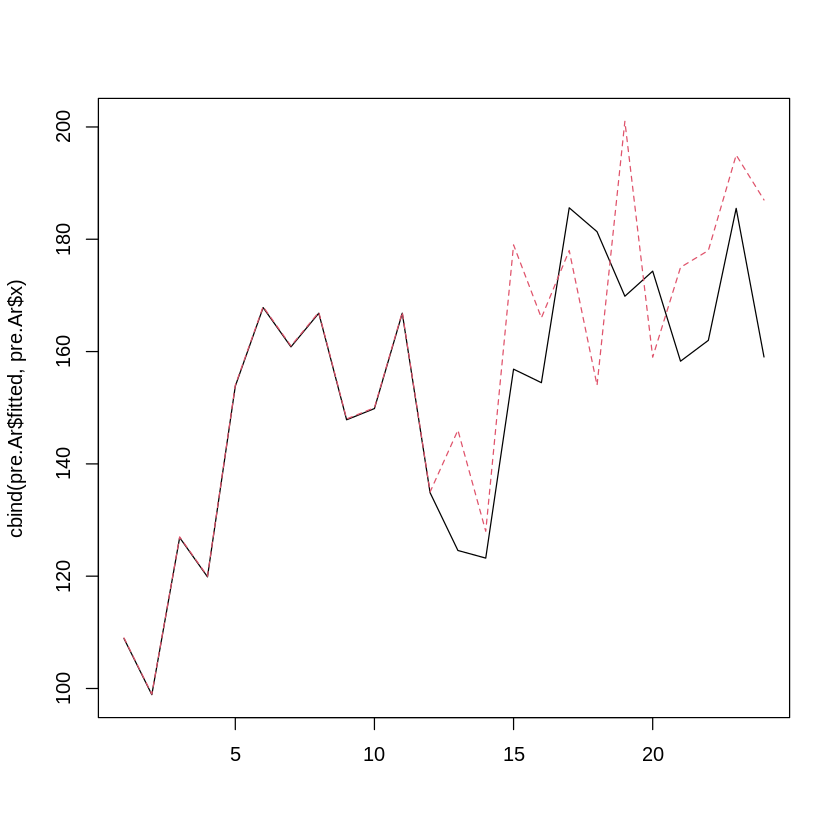

In [ ]:
pre_ar<-predict(fit_arima, n.ahead=24)
matplot(1:24,cbind(transposed_criminal_matrix[8,97:120],pre_ar$pred),type="l",main="", xlab="Month", ylab="Number of crime case")
fit.Ar <- Arima(transposed_criminal_matrix[8,1:96],order=c(2,0,0),seasonal=list(order =c(2,1,3),period=12))
pre.Ar <- Arima(transposed_criminal_matrix[8, 97:(ncol(transposed_criminal_matrix))], model=fit.Ar)
matplot(cbind(pre.Ar$fitted, pre.Ar$x), type="l")

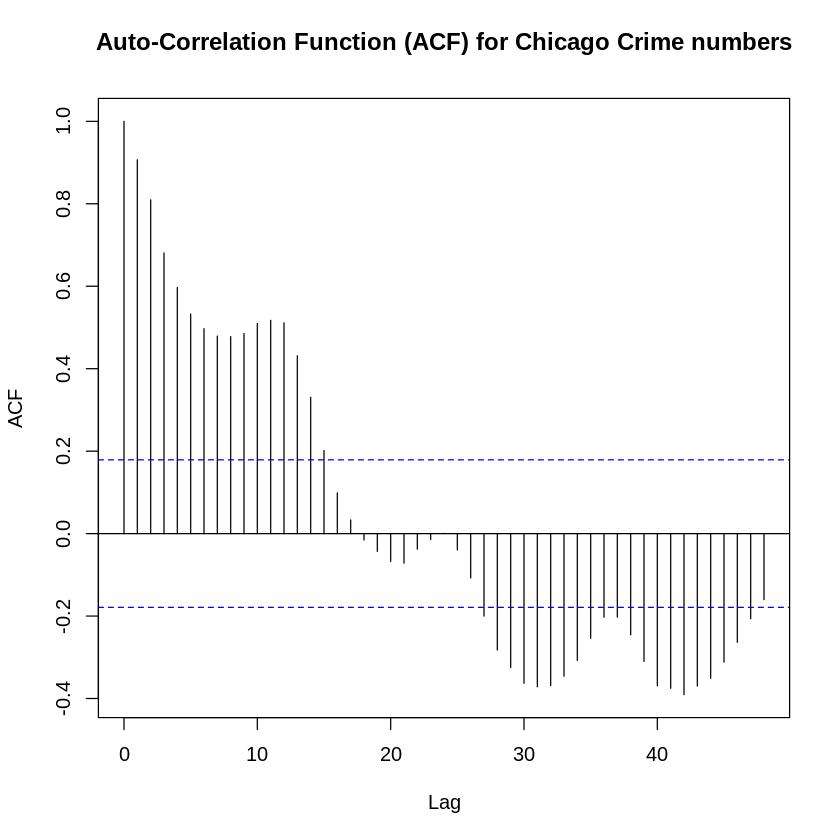

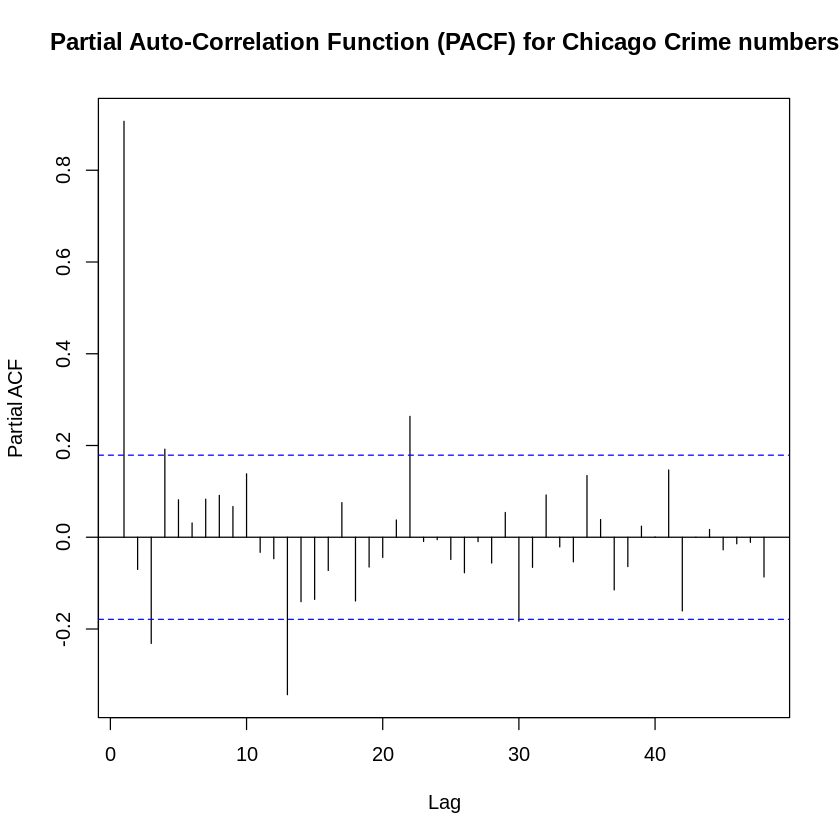

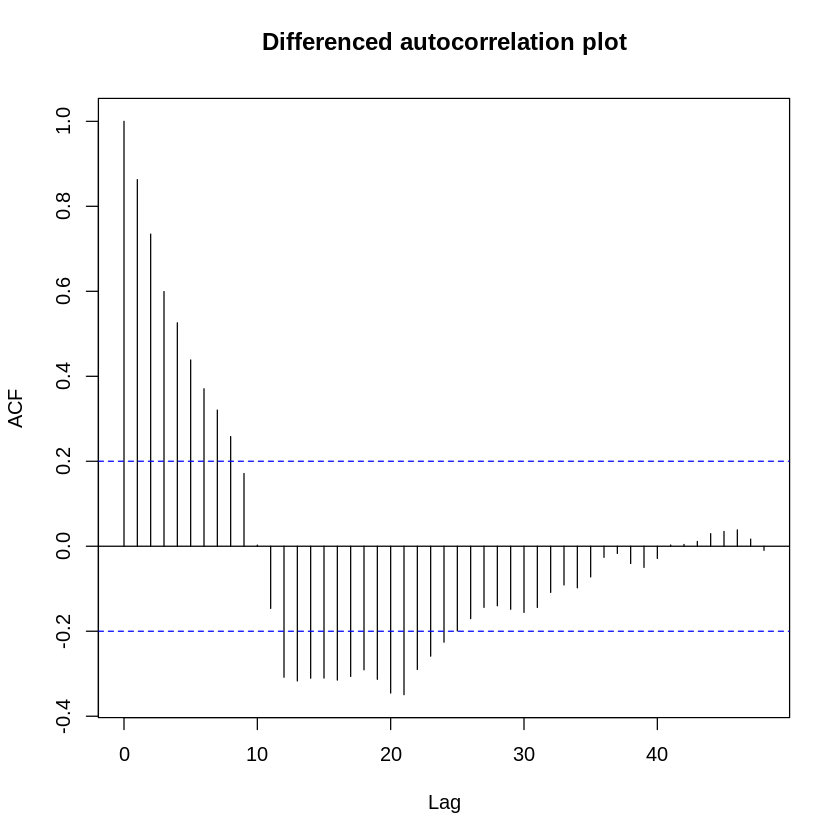

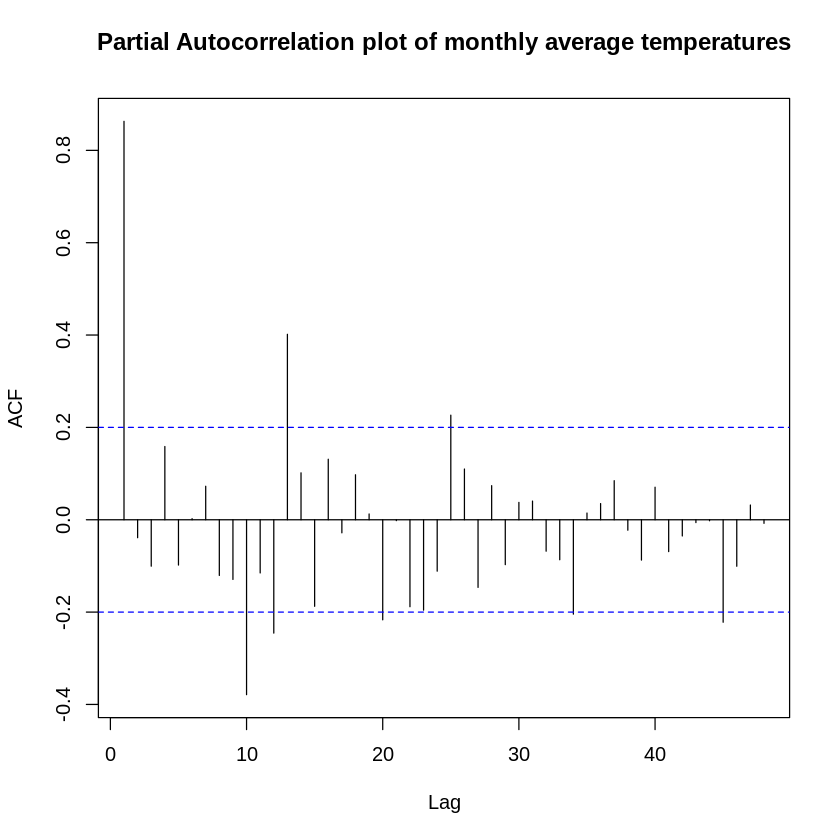

In [78]:
theft_acf<-acf(transposed_theft_matrix[18,], lag.max=48, main="Auto-Correlation Function (ACF) for Chicago Crime numbers")
theft_pacf<-pacf(transposed_theft_matrix[18,], lag.max=48, main="Partial Auto-Correlation Function (PACF) for Chicago Crime numbers")
theft.s.diff <- diff(transposed_theft_matrix[18,], lag=12, differences=2)
theft_diff_acf<-acf(theft.s.diff, lag.max=48, xlab="Lag", ylab="ACF", main="Differenced autocorrelation plot")

theft_diff_pacf<-pacf(theft.s.diff, lag.max=48, xlab="Lag", ylab="ACF",main="Partial Autocorrelation plot of monthly average temperatures")

In [ ]:
print(theft_acf)
print(theft_pacf)
print(theft_diff_acf)
print(theft_diff_pacf)

In [ ]:
fit_arima <- arima(transposed_theft_matrix[18,1:96],order=c(2,0,1),seasonal=list(order =c(1,1,2),period=12))
fit_arima
NRMSE_fit <- NRMSE(res=fit_arima$residuals, obs=transposed_theft_matrix[18,1:96])
NRMSE_fit
residuals <- residuals(fit_arima)
box_test_result <- Box.test(residuals, type="Ljung-Box")
box_test_result



Call:
arima(x = transposed_theft_matrix[18, 1:96], order = c(2, 0, 1), seasonal = list(order = c(1, 
    1, 2), period = 12))

Coefficients:
         ar1     ar2     ma1     sar1     sma1     sma2
      0.0657  0.8502  0.8060  -0.8022  -0.0026  -0.9965
s.e.  0.2249  0.2119  0.2575   0.1304   0.5728   0.5713

sigma^2 estimated as 2273:  log likelihood = -459.09,  aic = 932.18

[1] 0.2826339


	Box-Ljung test

data:  residuals
X-squared = 0.85868, df = 1, p-value = 0.3541


In [79]:
tsdiag(fit_arima)

ERROR: Error in eval(expr, envir, enclos): object 'fit_arima' not found


In [ ]:
pre_ar<-predict(fit_arima, n.ahead=24)

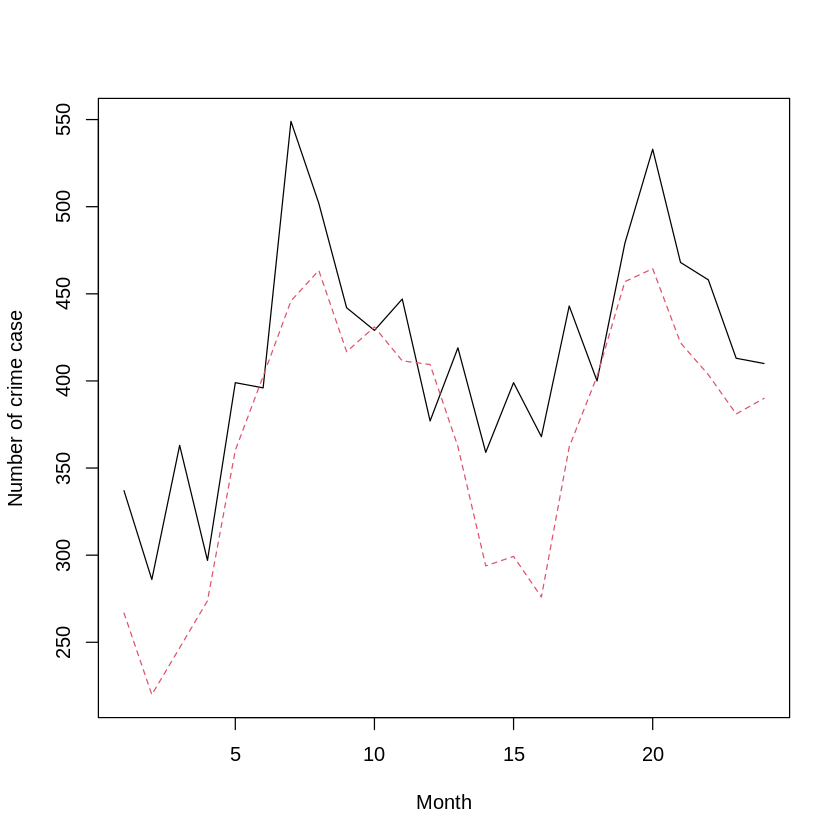

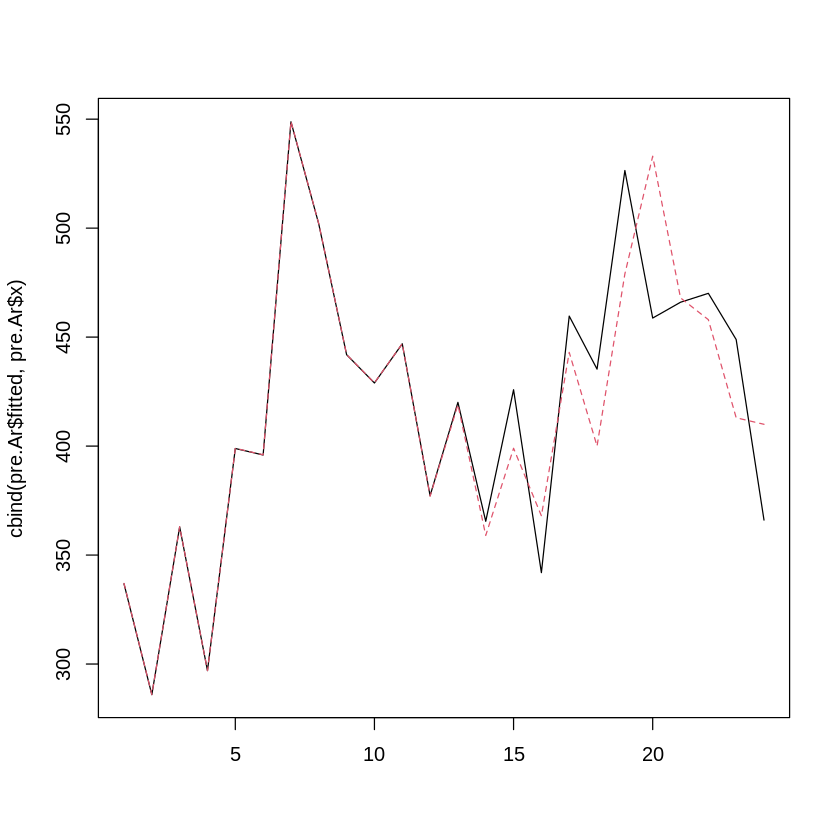

In [ ]:
pre_ar<-predict(fit_arima, n.ahead=24)
matplot(1:24,cbind(transposed_theft_matrix[18,97:120],pre_ar$pred),type="l",main="", xlab="Month", ylab="Number of crime case")
fit.Ar <- Arima(transposed_theft_matrix[18,1:96],order=c(1,1,2),seasonal=list(order =c(2,1,2),period=12))
pre.Ar <- Arima(transposed_theft_matrix[18, 97:(ncol(transposed_theft_matrix))], model=fit.Ar)
matplot(cbind(pre.Ar$fitted, pre.Ar$x), type="l")